# Trabajo Práctico N° 2 IA: Sistemas inteligentes


## 1. Importar librerias y cargar imagenes a utilizar


In [1]:
use_drive = True

In [4]:
import os
import re
import xml.etree.ElementTree as ET

import numpy as np
import seaborn as sns
import tensorflow as tf
if use_drive: from google.colab import drive
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model, to_categorical

In [3]:
if use_drive:
    drive.mount('/content/gdrive', force_remount=True)
    base_path = 'gdrive/MyDrive/IA-TP'
else:
    base_path =  os.getcwd()
training_path = base_path + '/images/Train'
test_path = base_path + '/images/Test'
cropped_training_path = base_path + '/cropped_images/Training'
cropped_test_path = base_path + '/cropped_images/Test'

## 2. Análisis de los datos a utilizar

En las carpetas **train** y **test** se encuentran imágenes de 770 x 600 de distintos jeroglíficos egipcios. Existen varias imagenes para un mismo jeroglífico, cada una de ellas con pequeñas variaciones en cuanto al ángulo o la posición. A continuación se muestran dos ejemplos:

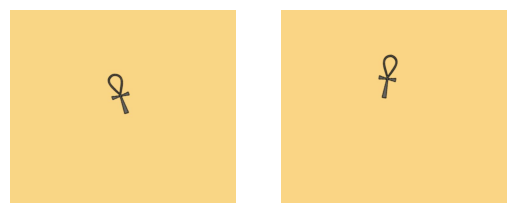

In [8]:
example_image_1 = Image.open(test_path + '/ankh (43).jpg')
example_image_2 = Image.open(test_path + '/ankh (47).jpg')

fig, axes = plt.subplots(1, 2)
axes[0].imshow(example_image_1)
axes[0].axis('off')
axes[1].imshow(example_image_2)
axes[1].axis('off')

plt.show()

El atributo objetivo (categoría del jeroglífico) se encuentra en un archivo XML que acompaña a cada imagen.
A su vez, este archivo incluye cuatro coordenadas que definen un Bounding Box (cuadro delimitador, en español), delimitando el área exacta de la imagen donde se encuentra el jeroglífico. Esto será muy util al preparar las imágenes, ya que como se ve en los ejemplos anteriores la mayor parte correspende al fondo, el cual no aporta información relevante para la clasificación.

## 3. Preparación de los datos
La preparación de los datos consistirá de los siguientes pasos:

1.   Recortar las imagenes de acuerdo al Bounding Box, como se explico en la sección anterior
2.   Redimensionar las imagenes, para que todas tengan el mismo tamaño, en este caso de 128 x 128 px
3.   Convertir las imagenes a una escala de grises, ya que los colores no son relevantes para la clasificación
4.   Transformar las imagenes en un vector y reescalar los valores en una escala entre 0 y 1
5.   Transformar el atributo objetivo de un "String" a un vector, utilizando el método de one-hot encoding
6.   Eliminar las siguientes categorías: "Head" ya que solo hay imagenes de la misma en los datos de prueba y 'Limits', 'Nile fish' y 'Foots', ya que las imágenes de estas 3 categorías son las mismas que las de otras 3, pero con otra etiqueta, lo que generaba problemas al entrenar el modelo. Decidimos eliminarlos y no cambiar su etiqueta ya que como se observará en las siguientes secciones cada categoría tiene aproximadamente la misma cantidad de ejemplos, por lo que se duplicaría la cantidad de ejemplos de solo de esas 3 categorías, desbalanceando los datos disponibles.


>Las funciones que están en la siguiente celda son para recortar las imagenes y generar un set de datos solo con imágenes, como lo pide la consigna. Si ya se tienen estos datos NO HACE FALTA ejecutarlas de vuelta, se puede trabajar con los datos ya generados. Ejecutarlas puede tardar bastatne tiempo, sobre todo en colab con Google Drive


In [ ]:
def crop_image(image_path, xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    xmin = int(root.find('.//bndbox/xmin').text)
    ymin = int(root.find('.//bndbox/ymin').text)
    xmax = int(root.find('.//bndbox/xmax').text)
    ymax = int(root.find('.//bndbox/ymax').text)
    
    image = Image.open(image_path)
    cropped_image = image.crop((xmin, ymin, xmax, ymax))
    return cropped_image
    
def crop_images_and_save(source, dest, quiet=True):
    if not os.path.exists(dest):
        os.makedirs(dest)  # Crea el directorio si no existe
    skip = {'head.jpg', 'limits.jpg', 'nile fish.jpg', 'foot.jpg'}
    for i, file in enumerate(os.listdir(source)):
        if not quiet:
            print(f"Procesando {file} ({i+1}/{len(os.listdir(source))})")
        if file.endswith('.jpg') and re.sub(r'\s*\(\d+\)', '', file).strip() not in skip:
            image_path = os.path.join(source, file)
            xml_path = image_path.replace('.jpg', '.xml')
            if os.path.exists(xml_path):
                image = crop_image(image_path, xml_path)
                image.save(os.path.join(dest, file))
            elif not quiet:
                print(f"Saltando {file} ya que no se encontró el archivo XML correspondiente")
                
# Esto puede llevar bastante tiempo, sobre todo en colab si se lee de drive
crop_images_and_save(training_path, cropped_training_path)
crop_images_and_save(test_path, cropped_test_path)

In [5]:
def process_image(image_path):
    image = Image.open(image_path)
    resized_image = image.resize((128, 128))
    grayscale_image = resized_image.convert('L')
    rescaled_image = np.array(grayscale_image) / 255.0
    return rescaled_image

def process_images(dir_path, quiet=True):
    images = []
    categories = []
    for i, file in enumerate(os.listdir(dir_path)):
        if not quiet:
            print(f"Procesando {file} ({i+1}/{len(os.listdir(dir_path))})")
        image_path = os.path.join(dir_path, file)
        images.append(process_image(image_path))
        category = re.sub(r'\s*\(\d+\)', '', file).strip().capitalize()
        categories.append(category)
    return np.array(images), np.array(categories)

def get_one_hot_encoding(categories, category_to_int_map):
    vec = [category_to_int_map[category] for category in categories]
    return to_categorical(vec)

In [6]:
# Esto puede llevar un tiempo, sobre todo en colab si se lee de drive
processed_training_images, processed_training_categories = process_images(cropped_training_path)
processed_test_images, processed_test_categories= process_images(cropped_test_path)

In [7]:
category_to_int_map = {category: index for index, category in enumerate(np.unique(processed_training_categories))}
encoded_training_categories = get_one_hot_encoding(processed_training_categories, category_to_int_map)
encoded_test_categories = get_one_hot_encoding(processed_test_categories, category_to_int_map)

## 4. Distribución de los datos

El set de datos utilizado ya contaba con la división entre datos de prueba y datos de entrenamiento, a continuación se muestra la información principal de cada uno.

In [8]:
training_quantity = len(processed_training_images)
test_quantity = len(processed_test_images)

print(f"Cantidad de datos totales: {training_quantity + test_quantity}")
print(f"Cantidad de datos de entrenamiento: {training_quantity}")
print(f"Porcentaje de datos de entrenamiento: {training_quantity / (training_quantity + test_quantity):.2%}")
print(f"Cantidad de datos de prueba: {test_quantity}")
print(f"Porcentaje de datos de prueba: {test_quantity / (training_quantity + test_quantity):.2%}")


training_category_counts = dict(zip(*np.unique(processed_training_categories, return_counts=True)))
test_category_counts = dict(zip(*np.unique(processed_test_categories, return_counts=True)))
category_count = len(training_category_counts.keys())
print(f"\nCantidad de categorías: {category_count}")
print(f"Cantidad de ejemplos por categoría en datos de entrenamiento: {training_category_counts}")
print(f"Cantidad de ejemplos por categoría en datos de prueba: {test_category_counts}")

Cantidad de datos totales: 4772
Cantidad de datos de entrenamiento: 3766
Porcentaje de datos de entrenamiento: 78.92%
Cantidad de datos de prueba: 1006
Porcentaje de datos de prueba: 21.08%

Cantidad de categorías: 92
Cantidad de ejemplos por categoría en datos de entrenamiento: {'100.jpg': 41, 'Among.jpg': 41, 'Angry.jpg': 41, 'Ankh.jpg': 41, 'Aroura.jpg': 41, 'At.jpg': 41, 'Bad thinking.jpg': 41, 'Bandage.jpg': 41, 'Bee.jpg': 41, 'Belongs.jpg': 41, 'Birth.jpg': 41, 'Board game.jpg': 41, 'Book.jpg': 41, 'Boy.jpg': 40, 'Branch.jpg': 41, 'Bread.jpg': 41, 'Brewer.jpg': 41, 'Builder.jpg': 41, 'Bury.jpg': 41, 'Canal.jpg': 41, 'Cloth on pole.jpg': 41, 'Cobra.jpg': 41, 'Composite_bow.jpg': 41, 'Cooked.jpg': 41, 'Corpse.jpg': 41, 'Dessert.jpg': 41, 'Divide.jpg': 41, 'Duck.jpg': 41, 'Elephant.jpg': 41, 'Enclosed mound.jpg': 41, 'Eye.jpg': 41, 'Fabric.jpg': 41, 'Face.jpg': 41, 'Falcon.jpg': 41, 'Fingre.jpg': 41, 'Fish.jpg': 41, 'Flail.jpg': 41, 'Folded.jpg': 41, 'Galena.jpg': 41, 'Giraffe.jpg':

Según lo pedido en el trabajo, el set de prueba debe contener al menos el 25% de los ejemplo totales. Para resolver este problema decidimos tomar 2 ejemplos al azar de cada categoría y moverlos a los datos de prueba. Esto nos permite obtener 184 nuevos ejemplos de prueba y no debería afectar en gran medida al entrenamiento

In [9]:
for category in range(category_count):
    indices_category = np.where(encoded_training_categories[:, category] == 1)[0]
    selected_indices = np.random.choice(indices_category, size=2, replace=False)

    processed_test_images = np.vstack((processed_test_images, processed_training_images[selected_indices]))
    encoded_test_categories = np.vstack((encoded_test_categories, encoded_training_categories[selected_indices]))

    processed_training_images = np.delete(processed_training_images, selected_indices, axis=0)
    encoded_training_categories = np.delete(encoded_training_categories, selected_indices, axis=0)


Una vez realizado esto el porcentaje aumenta hasta un 24.94%

In [10]:
training_quantity = len(processed_training_images)
test_quantity = len(processed_test_images)

print(f"Cantidad de datos totales: {training_quantity + test_quantity}")
print(f"Cantidad de datos de entrenamiento: {training_quantity}")
print(f"Porcentaje de datos de entrenamiento: {training_quantity / (training_quantity + test_quantity):.2%}")
print(f"Cantidad de datos de prueba: {test_quantity}")
print(f"Porcentaje de datos de prueba: {test_quantity / (training_quantity + test_quantity):.2%}")

Cantidad de datos totales: 4772
Cantidad de datos de entrenamiento: 3582
Porcentaje de datos de entrenamiento: 75.06%
Cantidad de datos de prueba: 1190
Porcentaje de datos de prueba: 24.94%


El último paso a realizar en cuanto a la distribución de los datos es crear un set de validación. Para esto utilizaremos la funcion train_test_split de la libreria scikit-learn, separando un 10% de los datos de entrenamiento disponibles.

In [11]:
x_train, x_validation, y_train, y_validation = train_test_split(processed_training_images,
                                                              encoded_training_categories,
                                                              test_size=0.1, shuffle=True)

#Esto lo hago para mantener la convencion de nombres
x_test, y_test = processed_test_images, encoded_test_categories


Cantidad de datos totales: 4772
Cantidad de datos de entrenamiento: 3223
Cantidad de datos de validación: 359
Cantidad de datos de prueba: 1190


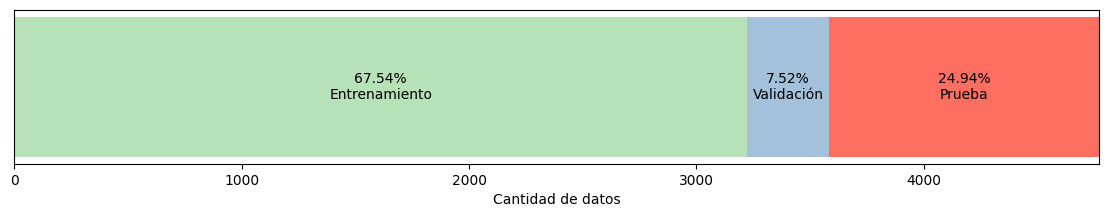

In [12]:
data = [len(x_train), len(x_validation), len(x_test)]
labels = ['Entrenamiento', 'Validación', 'Prueba']
total = sum(data)

print(f"Cantidad de datos totales: {total}")
print(f"Cantidad de datos de entrenamiento: {data[0]}")
print(f"Cantidad de datos de validación: {data[1]}")
print(f"Cantidad de datos de prueba: {data[2]}")

colors = ["#B7E1B7", "#A3C1DA", "#FF6F61"]

plt.figure(figsize=(14, 2))
plt.xlabel("Cantidad de datos")
plt.xlim(0,total)

plt.barh([0], data[0], color=colors[0])
plt.barh([0], data[1], left=data[0], color=colors[1])
plt.barh([0], data[2], left=data[0] + data[1], color=colors[2])

plt.yticks([])

aux = 0
for label, value in zip(labels, data):
    percentage = value / total
    text = f"{percentage:.2%}\n{label}"
    plt.text(aux + value/2, 0, text, va="center", ha="center")
    aux += value

plt.show()


## 5. Definición de la Red y Entrenamiento


In [13]:
def plot_training_history(history, figsize):
    plt.figure(figsize=figsize)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Gráfico del Error del Entrenamiento')
    plt.ylabel('')
    plt.xlabel('epoch')
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    plt.show()

    plt.figure(figsize=figsize)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Gráfico de la Exactitud del Entrenamiento')
    plt.ylabel('')
    plt.xlabel('epoch')
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    plt.show()

def show_model_performance(x, y, model, data_type, existing_categories,figsize=(20,20)):
    prediction = model.predict(x, verbose=0)
    predicted_categories = []
    real_categories = []
    for i in range(len(x)):
        real_category = existing_categories[np.argmax(y[i])]
        predicted_category = existing_categories[np.argmax(prediction[i], axis=0)]
       
        predicted_categories.append(predicted_category)
        real_categories.append(real_category)

    print("\n Reporte de Clasificación: ")
    print(classification_report(real_categories, predicted_categories, zero_division=0))

    cm = confusion_matrix(real_categories, predicted_categories, labels=existing_categories)
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('Predicción')
    plt.ylabel('True Label')
    plt.title(f'Matriz de confusión para {model.name} con datos de {data_type}')
    plt.xticks(np.arange(len(existing_categories)) + 0.5, existing_categories, rotation=90)
    plt.yticks(np.arange(len(existing_categories)) + 0.5, existing_categories)
    plt.show()

def save_model(model):
    tf.keras.models.save_model(model, f'{base_path}/modelos_entrenados/{model.name}.keras')

### 5.1 RNA Multi-Perceptrón Backpropagation

#### 5.1.1 Primer intento RNA MLP
La primera red RNA MLP a utilizar recibe las imágenes de 128x128 píxeles con un canal, las aplana y las pasa por cuatro capas densas. La primera capa tiene 512 neuronas, seguida de capas con 256, 64 y 32 neuronas respectivamente, todas con activación ReLU. La capa de salida utiliza una activación softmax con tantas neuronas como categorías a clasificar. El optimizador seleccionado es SGD con una tasa de aprendizaje de 0.01 y se aplica Early Stopping con paciencia de 15 épocas.

In [14]:
mlp_1_inputs = tf.keras.Input(shape=(128, 128, 1))
x = tf.keras.layers.Flatten()(mlp_1_inputs)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
mlp_1_outputs = tf.keras.layers.Dense(category_count, activation="softmax")(x)

mlp_1 = Model(inputs=mlp_1_inputs, outputs=mlp_1_outputs, name = "MLP_1")

In [15]:
mlp_early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=15, restore_best_weights=True
)

mlp_1.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
mlp_1.summary()

Model: "MLP_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 512)               8389120   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 92)                3036  

In [17]:
mlp_1_history = mlp_1.fit(x_train, y_train, epochs=250,
                    validation_data=(x_validation, y_validation),
                    callbacks=[mlp_early_stopping])

Epoch 1/250
101/101 [==============================] - 6s 56ms/step - loss: 4.5295 - accuracy: 0.0140 - val_loss: 4.5207 - val_accuracy: 0.0084
Epoch 2/250
101/101 [==============================] - 6s 56ms/step - loss: 4.5201 - accuracy: 0.0140 - val_loss: 4.5321 - val_accuracy: 0.0111
Epoch 3/250
101/101 [==============================] - 5s 47ms/step - loss: 4.5145 - accuracy: 0.0158 - val_loss: 4.5078 - val_accuracy: 0.0139
Epoch 4/250
101/101 [==============================] - 6s 56ms/step - loss: 4.5017 - accuracy: 0.0158 - val_loss: 4.4961 - val_accuracy: 0.0111
Epoch 5/250
101/101 [==============================] - 4s 42ms/step - loss: 4.4841 - accuracy: 0.0180 - val_loss: 4.4844 - val_accuracy: 0.0223
Epoch 6/250
101/101 [==============================] - 5s 52ms/step - loss: 4.4592 - accuracy: 0.0195 - val_loss: 4.4786 - val_accuracy: 0.0167
Epoch 7/250
101/101 [==============================] - 4s 44ms/step - loss: 4.4215 - accuracy: 0.0270 - val_loss: 4.4535 - val_accuracy:

In [48]:
save_model(mlp_1)

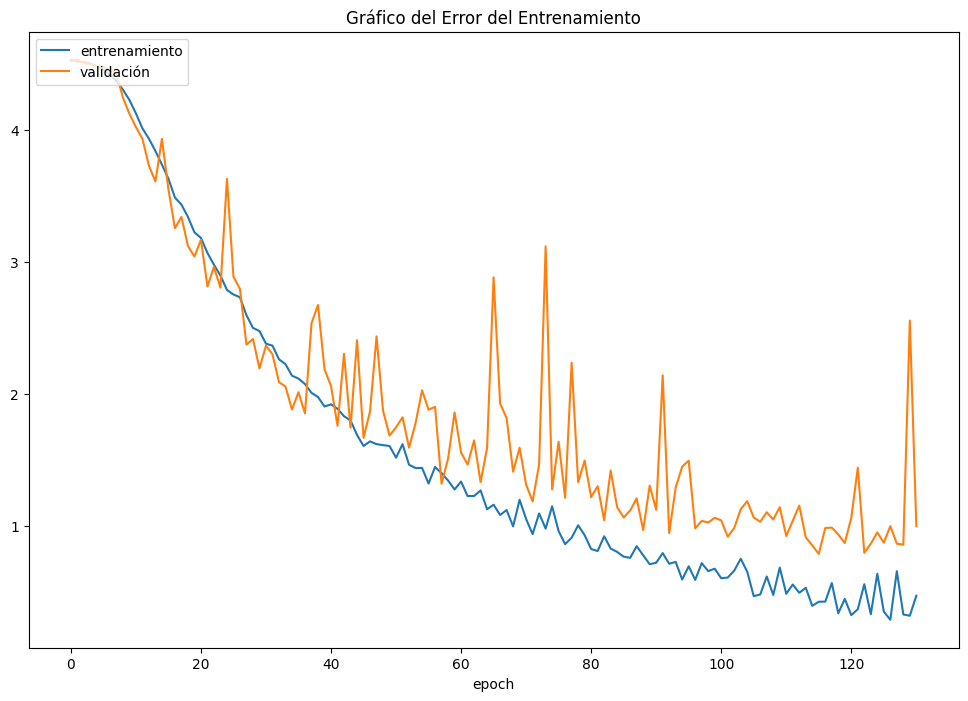

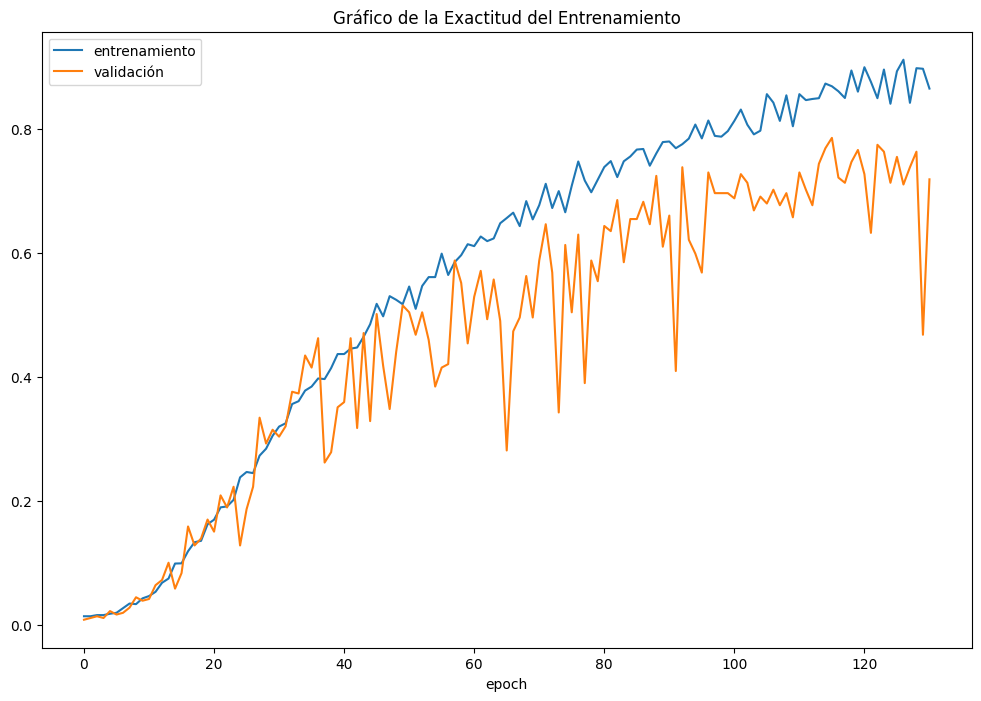

In [18]:
plot_training_history(mlp_1_history, (12,8))


 Reporte de Clasificación: 
                           precision    recall  f1-score   support

                  100.jpg       0.97      0.97      0.97        36
                Among.jpg       0.97      0.97      0.97        36
                Angry.jpg       0.89      0.94      0.92        36
                 Ankh.jpg       0.80      0.92      0.86        36
               Aroura.jpg       0.86      0.83      0.85        36
                   At.jpg       0.97      0.94      0.96        36
         Bad thinking.jpg       0.85      0.85      0.85        34
              Bandage.jpg       0.75      1.00      0.86        36
                  Bee.jpg       0.97      0.92      0.94        36
              Belongs.jpg       0.73      0.79      0.76        34
                Birth.jpg       0.83      1.00      0.91        35
           Board game.jpg       1.00      0.89      0.94        36
                 Book.jpg       0.74      0.83      0.78        35
                  Boy.jpg       

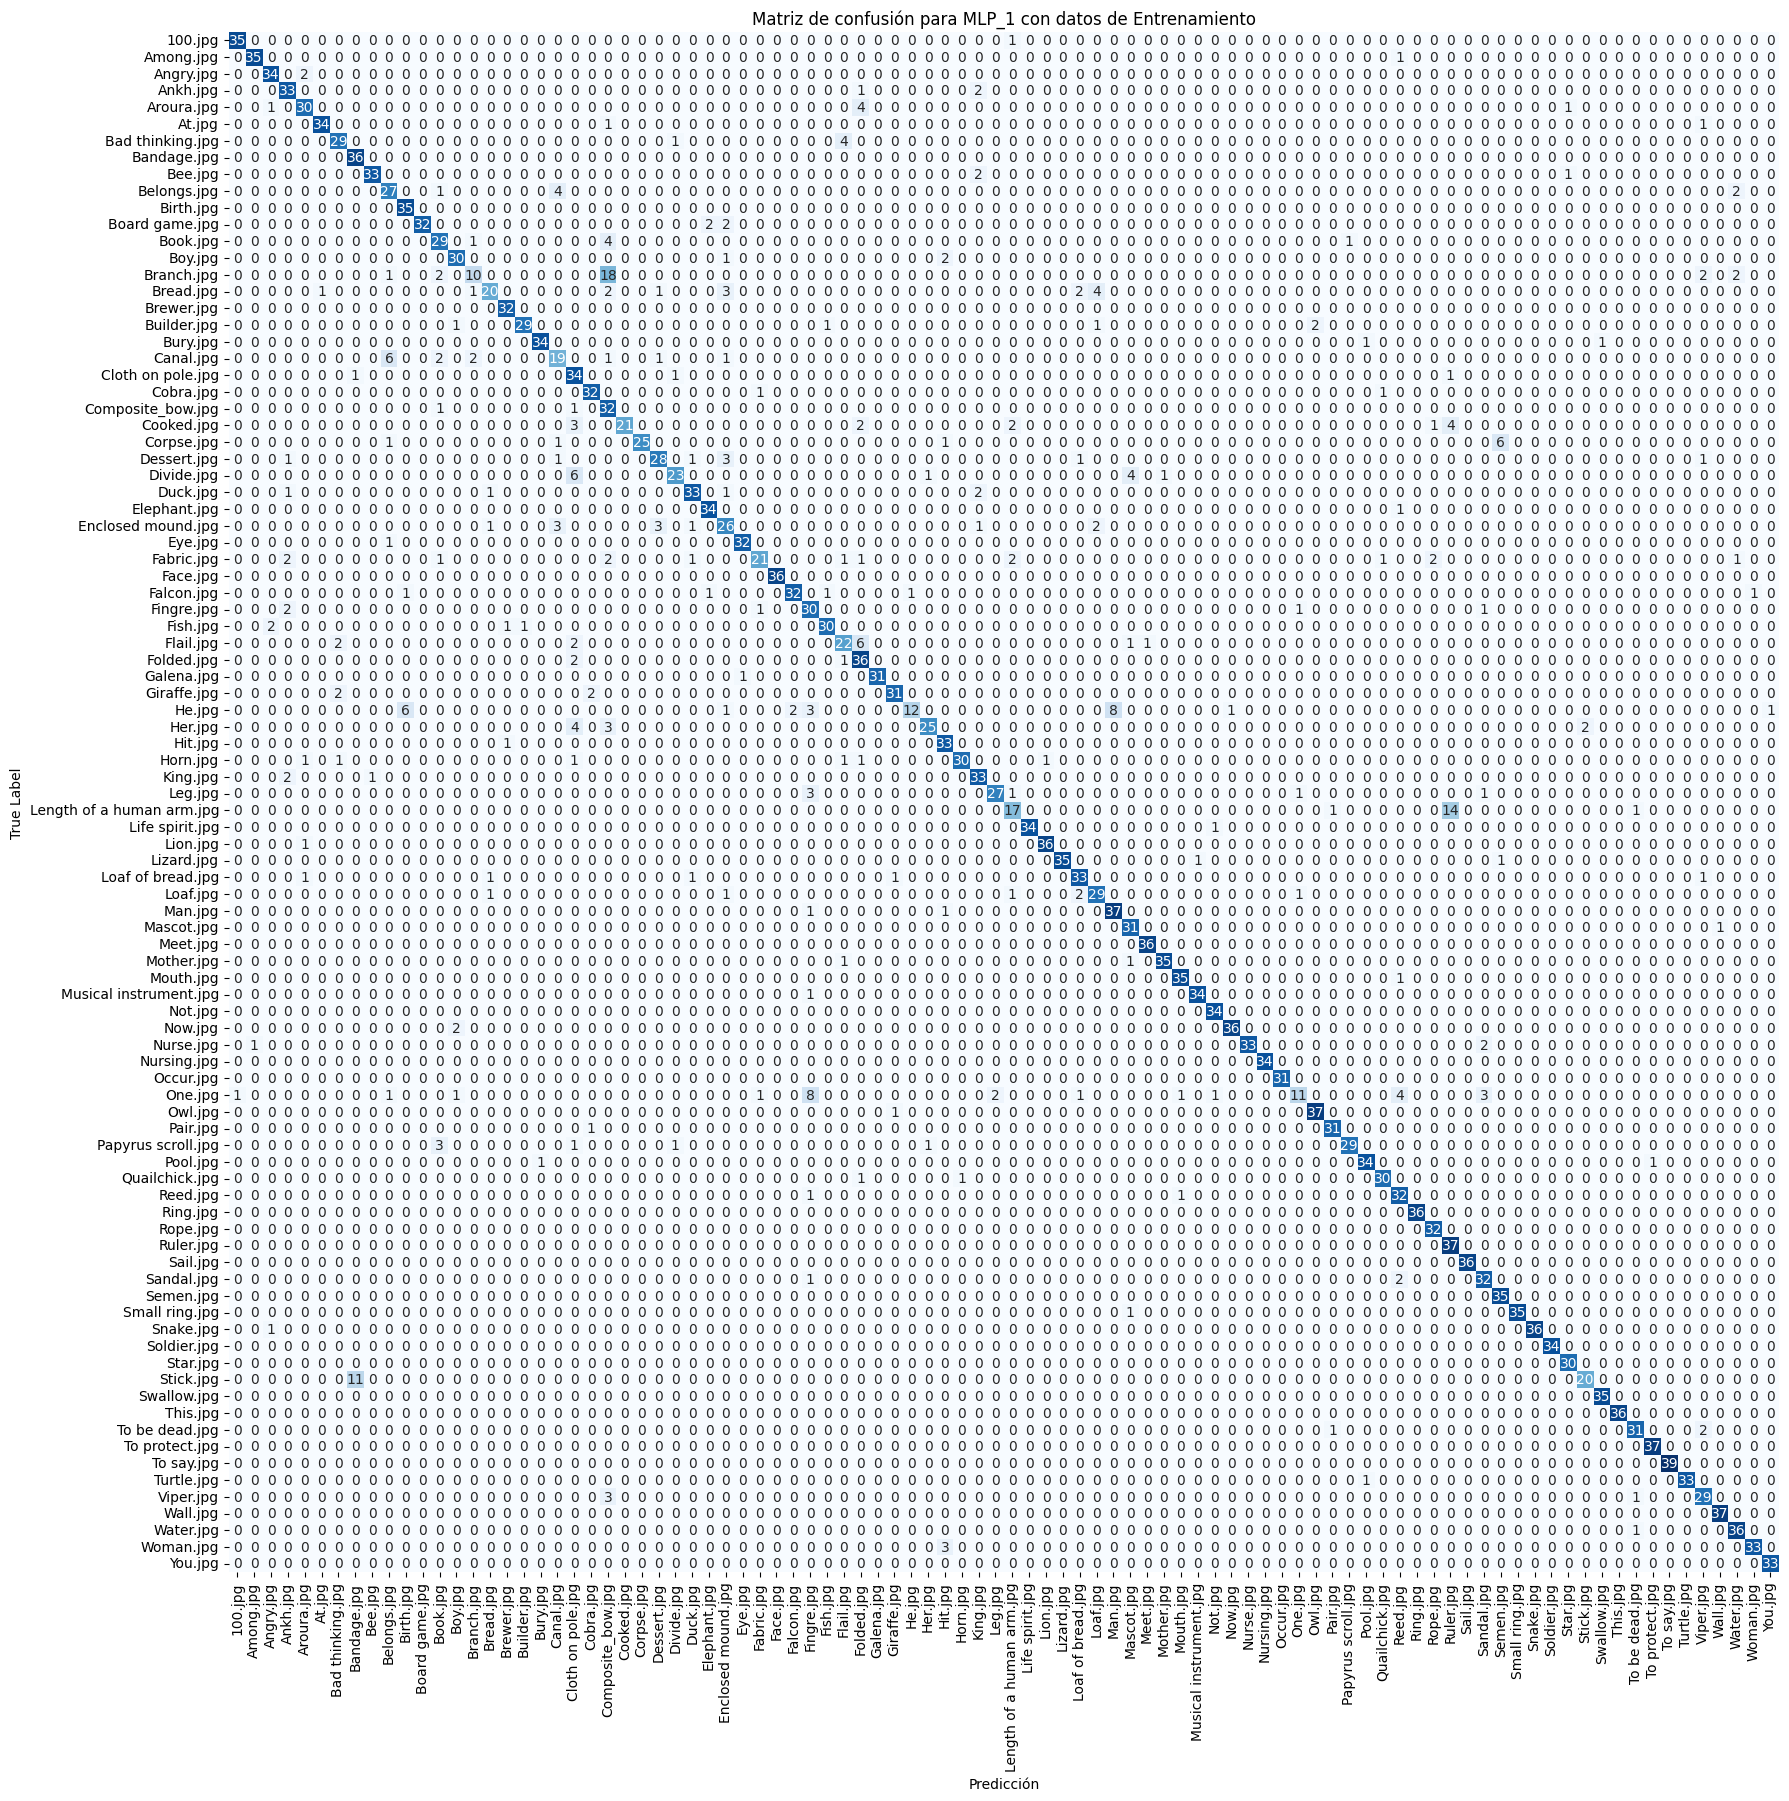

In [25]:
show_model_performance(x_train, y_train, mlp_1, "Entrenamiento", list(training_category_counts.keys()))


 Reporte de Clasificación: 
                           precision    recall  f1-score   support

                  100.jpg       0.86      0.92      0.89        13
                Among.jpg       1.00      1.00      1.00        13
                Angry.jpg       0.75      0.92      0.83        13
                 Ankh.jpg       0.72      1.00      0.84        13
               Aroura.jpg       0.77      0.77      0.77        13
                   At.jpg       0.92      0.85      0.88        13
         Bad thinking.jpg       0.83      0.77      0.80        13
              Bandage.jpg       0.65      1.00      0.79        13
                  Bee.jpg       0.93      1.00      0.96        13
              Belongs.jpg       0.73      0.62      0.67        13
                Birth.jpg       0.75      0.92      0.83        13
           Board game.jpg       1.00      0.62      0.76        13
                 Book.jpg       0.57      0.62      0.59        13
                  Boy.jpg       

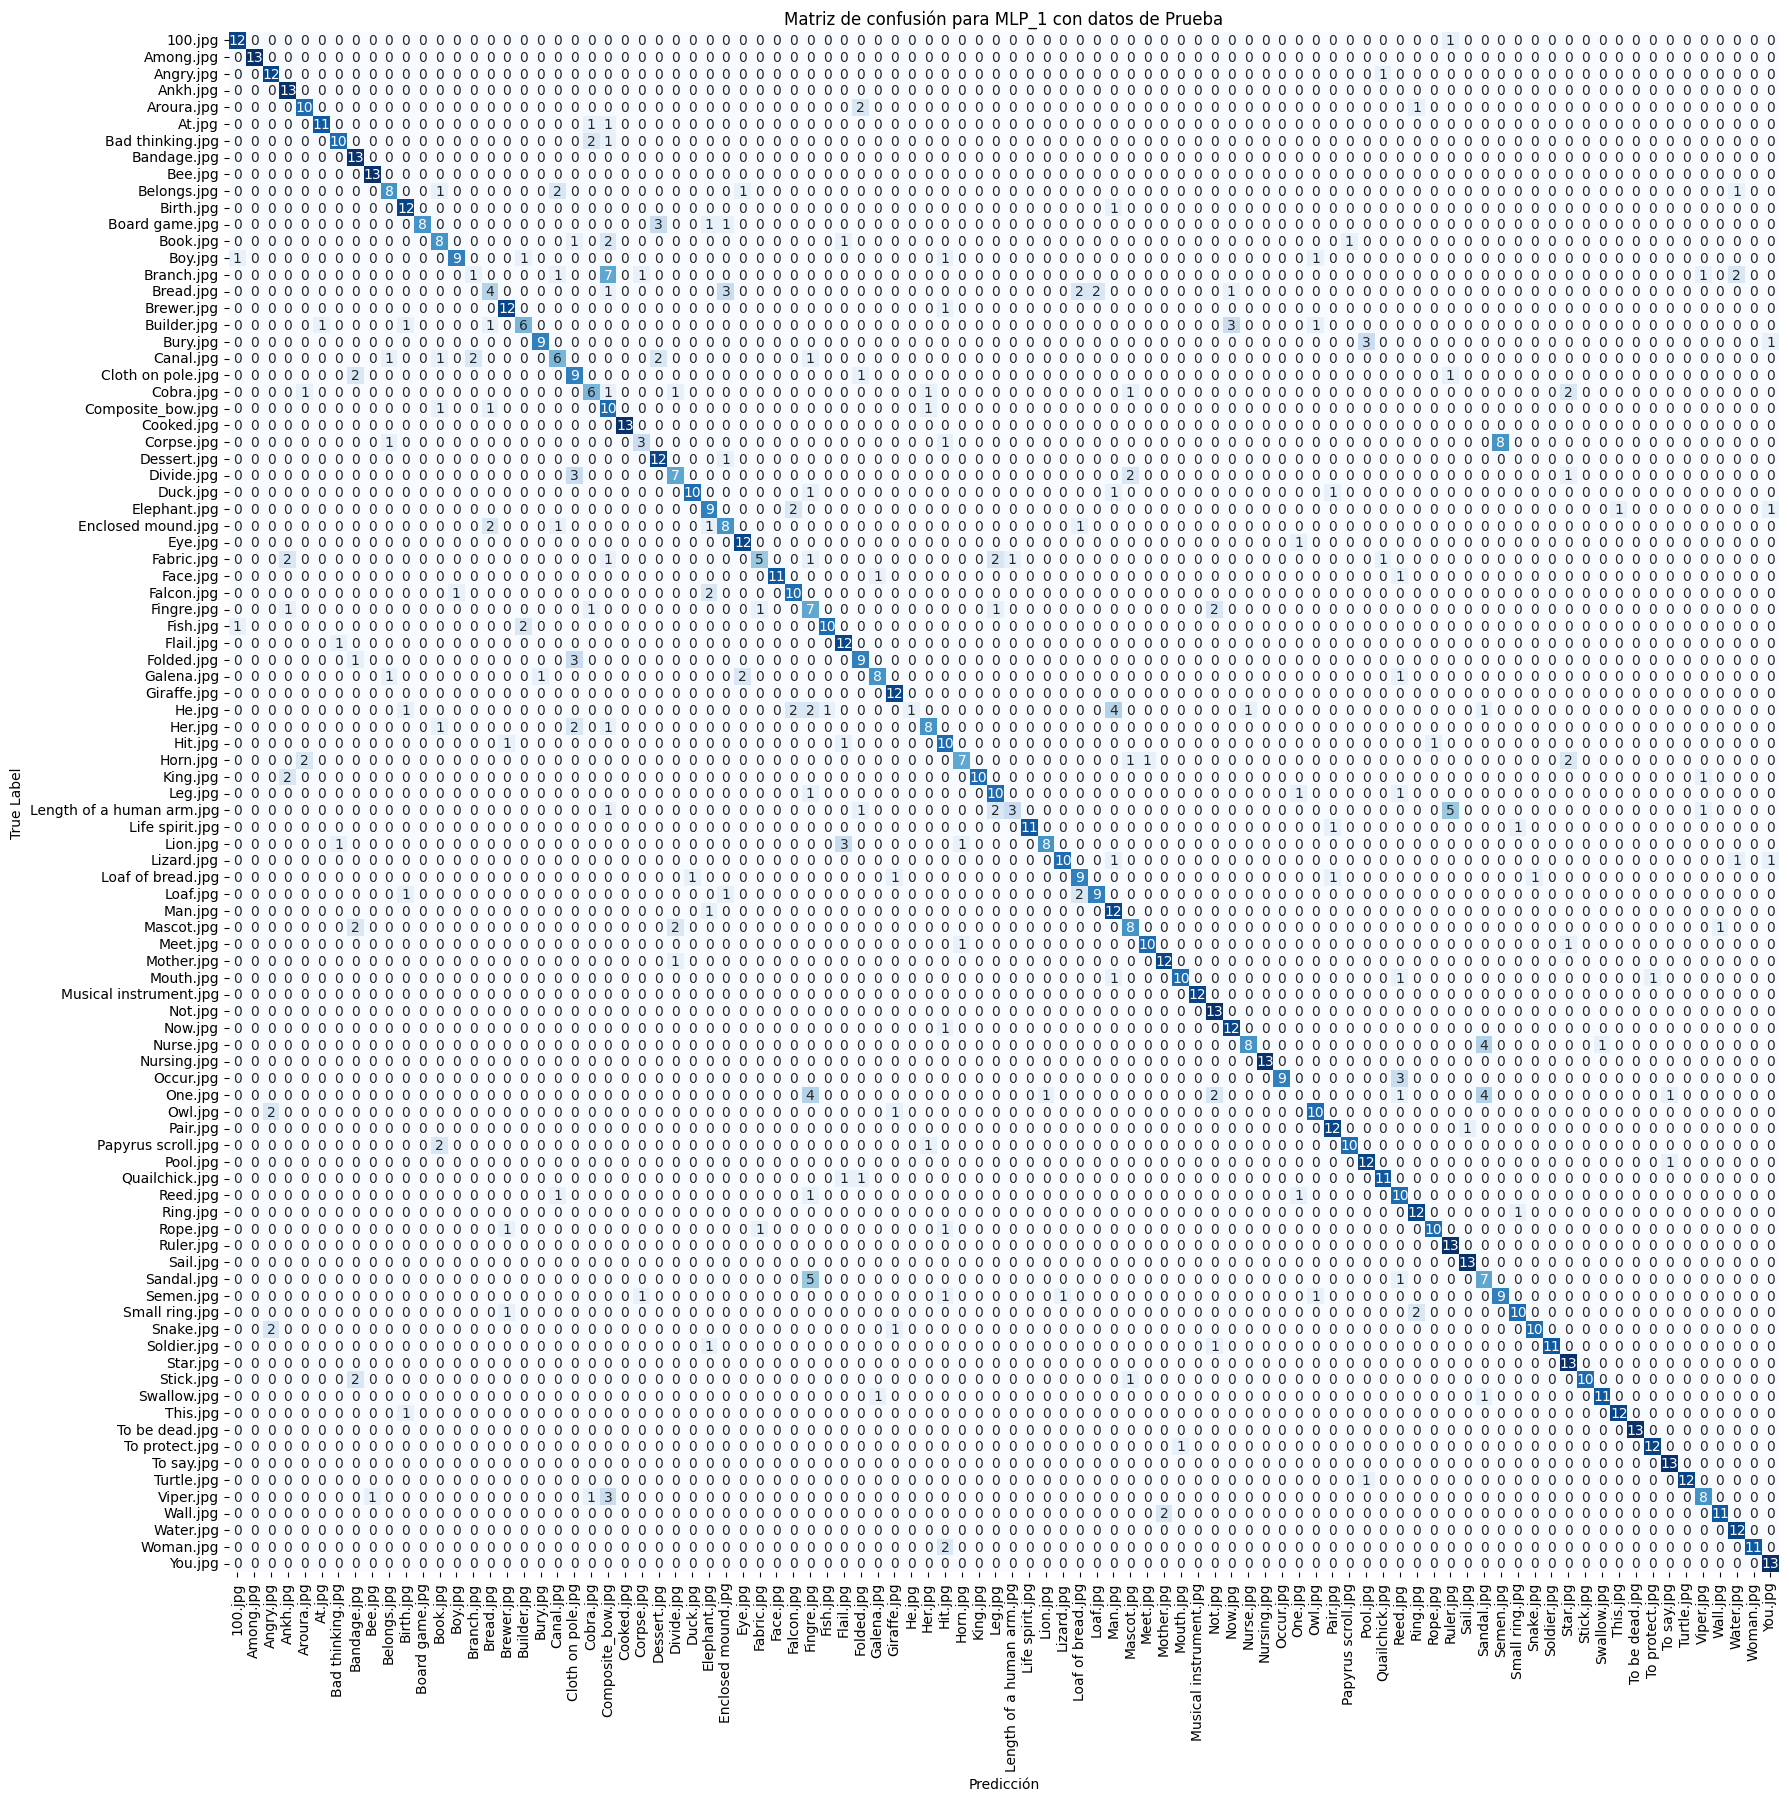

In [26]:
show_model_performance(x_test, y_test, mlp_1, "Prueba", list(training_category_counts.keys()))

#### 5.1.2 Segundo intento RNA MLP
A partir de los resultados del entrenamiento anterior se puede ver que el error con datos de entrenamiento disminuye de manera constante, mientras que, el error con datos de validación presenta mucha variación, con picos muy pronunciados, lo que puede indicar sobreajuste u overfitting. De manera similar, La exactitud de entrenamiento mejora constantemente, pero la exactitud de validación, aunque también mejora inicialmente, presenta cambios bruscos, lo cual refuerza la hipótesis de un posible sobreajuste.

A partir de este análisis para la nueva iteración se simplificará el modelo, reduciendo las dimensiones a partir de la segunda capa densa

In [40]:
mlp_2_inputs = tf.keras.Input(shape=(128, 128, 1))
x = tf.keras.layers.Flatten()(mlp_2_inputs)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
mlp_2_outputs = tf.keras.layers.Dense(category_count, activation="softmax")(x)

mlp_2 = tf.keras.Model(inputs=mlp_2_inputs, outputs=mlp_2_outputs, name="MLP_2")

In [41]:
mlp_2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [42]:
mlp_2.summary()

Model: "MLP_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 flatten_6 (Flatten)         (None, 16384)             0         
                                                                 
 dense_30 (Dense)            (None, 512)               8389120   
                                                                 
 dense_31 (Dense)            (None, 128)               65664     
                                                                 
 dense_32 (Dense)            (None, 64)                8256      
                                                                 
 dense_33 (Dense)            (None, 32)                2080      
                                                                 
 dense_34 (Dense)            (None, 92)                3036  

In [43]:
mlp_2_history = mlp_2.fit(x_train, y_train, epochs=250,
                    validation_data=(x_validation, y_validation),
                    callbacks=[mlp_early_stopping])

Epoch 1/250
101/101 [==============================] - 6s 50ms/step - loss: 4.5272 - accuracy: 0.0109 - val_loss: 4.5296 - val_accuracy: 0.0167
Epoch 2/250
101/101 [==============================] - 4s 41ms/step - loss: 4.5138 - accuracy: 0.0121 - val_loss: 4.5167 - val_accuracy: 0.0111
Epoch 3/250
101/101 [==============================] - 3s 32ms/step - loss: 4.4960 - accuracy: 0.0180 - val_loss: 4.5065 - val_accuracy: 0.0056
Epoch 4/250
101/101 [==============================] - 3s 33ms/step - loss: 4.4699 - accuracy: 0.0168 - val_loss: 4.4716 - val_accuracy: 0.0251
Epoch 5/250
101/101 [==============================] - 4s 36ms/step - loss: 4.4367 - accuracy: 0.0199 - val_loss: 4.4072 - val_accuracy: 0.0223
Epoch 6/250
101/101 [==============================] - 3s 31ms/step - loss: 4.3819 - accuracy: 0.0273 - val_loss: 4.3490 - val_accuracy: 0.0251
Epoch 7/250
101/101 [==============================] - 3s 33ms/step - loss: 4.3166 - accuracy: 0.0391 - val_loss: 4.3288 - val_accuracy:

In [47]:
save_model(mlp_2)

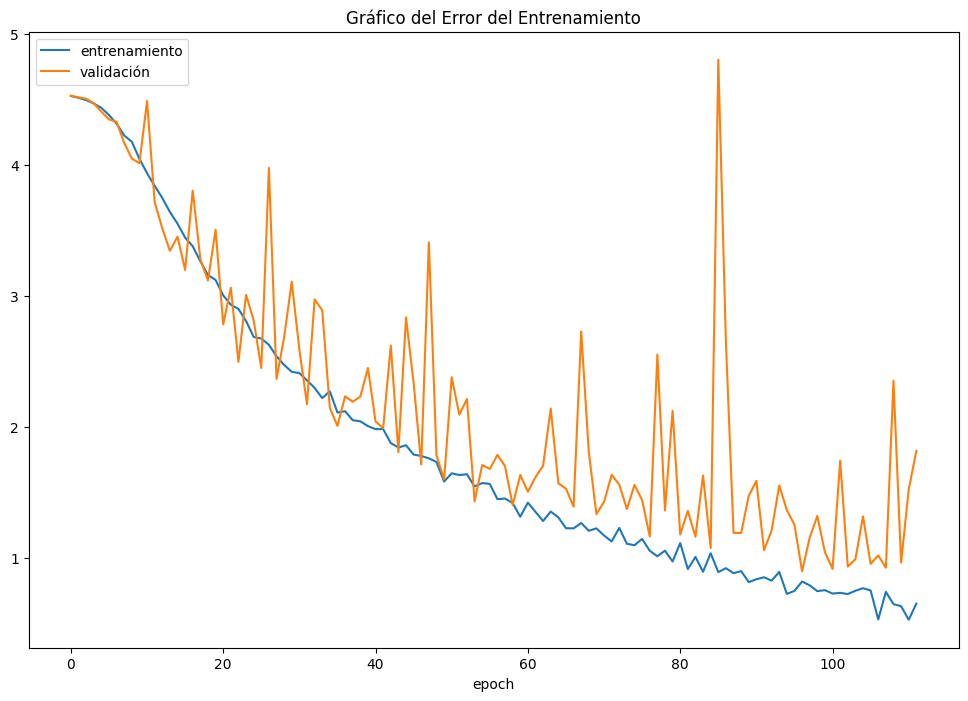

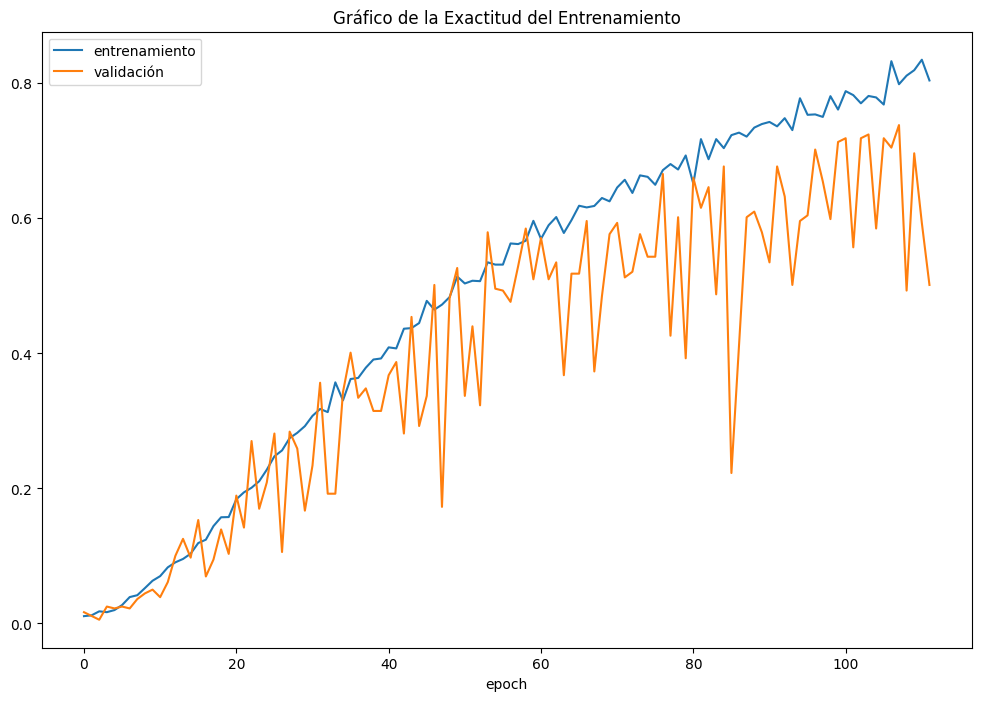

In [44]:
plot_training_history(mlp_2_history, (12,8))


 Reporte de Clasificación: 
                           precision    recall  f1-score   support

                  100.jpg       1.00      0.97      0.99        34
                Among.jpg       1.00      0.94      0.97        32
                Angry.jpg       0.91      0.97      0.94        33
                 Ankh.jpg       1.00      0.12      0.21        34
               Aroura.jpg       0.79      0.89      0.84        37
                   At.jpg       0.94      0.97      0.96        35
         Bad thinking.jpg       0.88      0.57      0.69        37
              Bandage.jpg       0.89      1.00      0.94        32
                  Bee.jpg       0.94      0.91      0.93        34
              Belongs.jpg       0.42      0.92      0.58        37
                Birth.jpg       0.89      0.97      0.93        35
           Board game.jpg       0.97      0.88      0.92        32
                 Book.jpg       0.72      1.00      0.84        33
                  Boy.jpg       

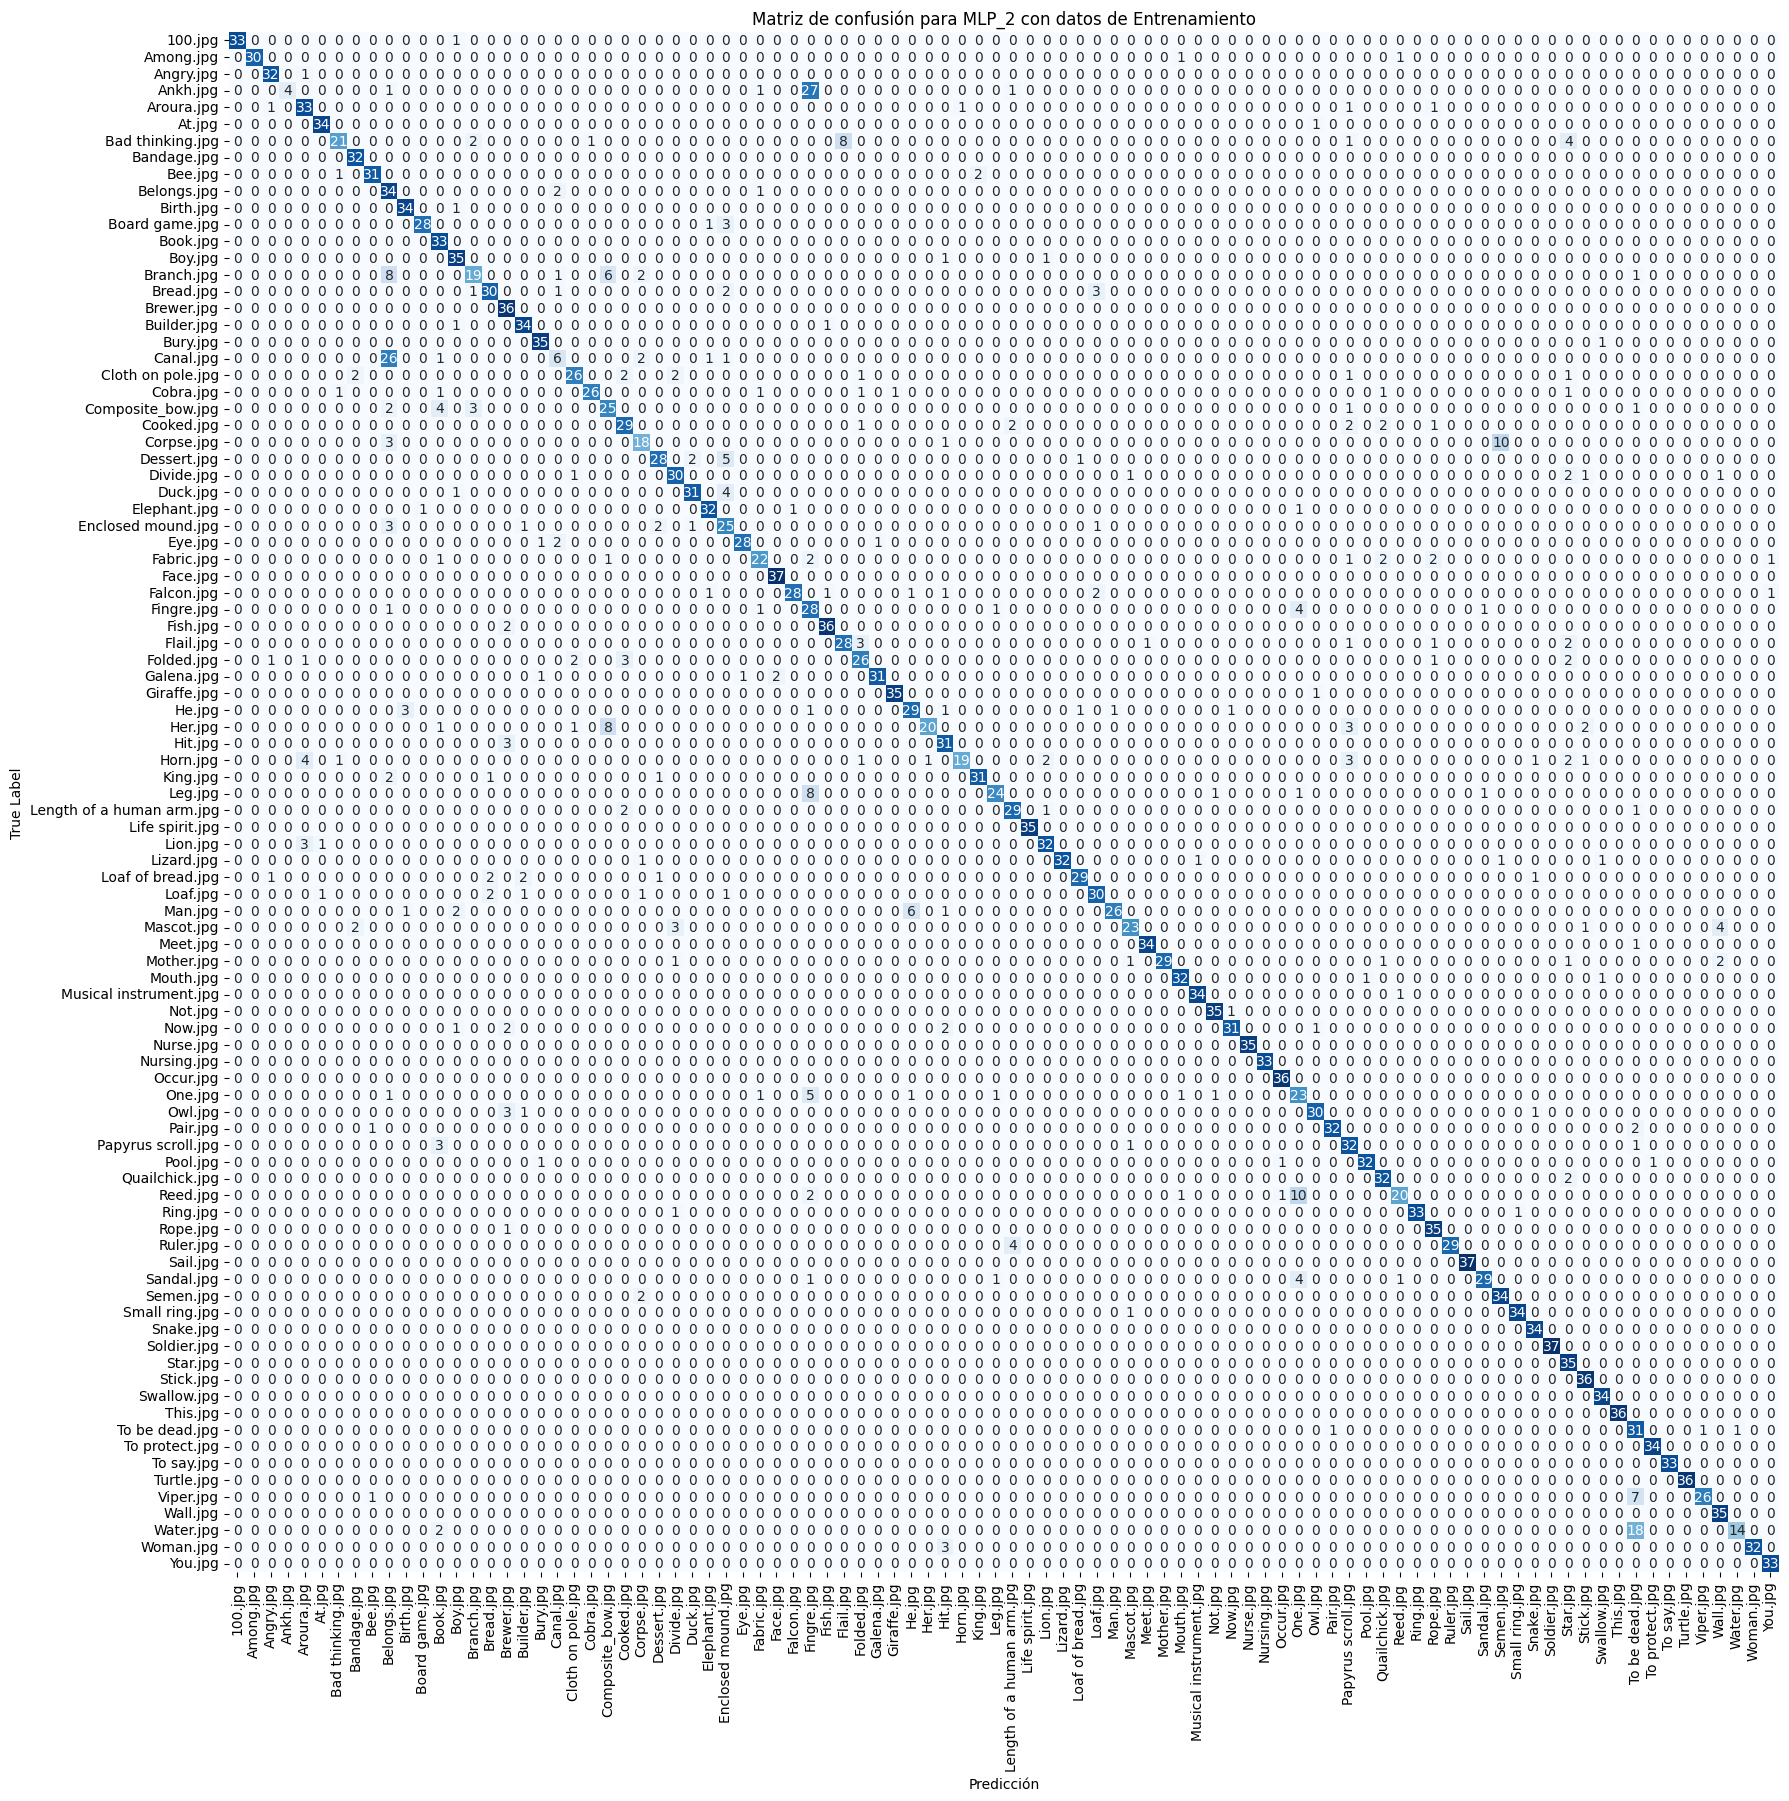

In [45]:
show_model_performance(x_train, y_train, mlp_2, "Entrenamiento", list(training_category_counts.keys()))


 Reporte de Clasificación: 
                           precision    recall  f1-score   support

                  100.jpg       0.83      0.77      0.80        13
                Among.jpg       0.83      0.77      0.80        13
                Angry.jpg       0.85      0.85      0.85        13
                 Ankh.jpg       1.00      0.08      0.14        13
               Aroura.jpg       0.47      0.69      0.56        13
                   At.jpg       0.80      0.62      0.70        13
         Bad thinking.jpg       0.75      0.23      0.35        13
              Bandage.jpg       0.72      1.00      0.84        13
                  Bee.jpg       0.93      1.00      0.96        13
              Belongs.jpg       0.39      0.85      0.54        13
                Birth.jpg       0.71      0.92      0.80        13
           Board game.jpg       0.89      0.62      0.73        13
                 Book.jpg       0.42      0.77      0.54        13
                  Boy.jpg       

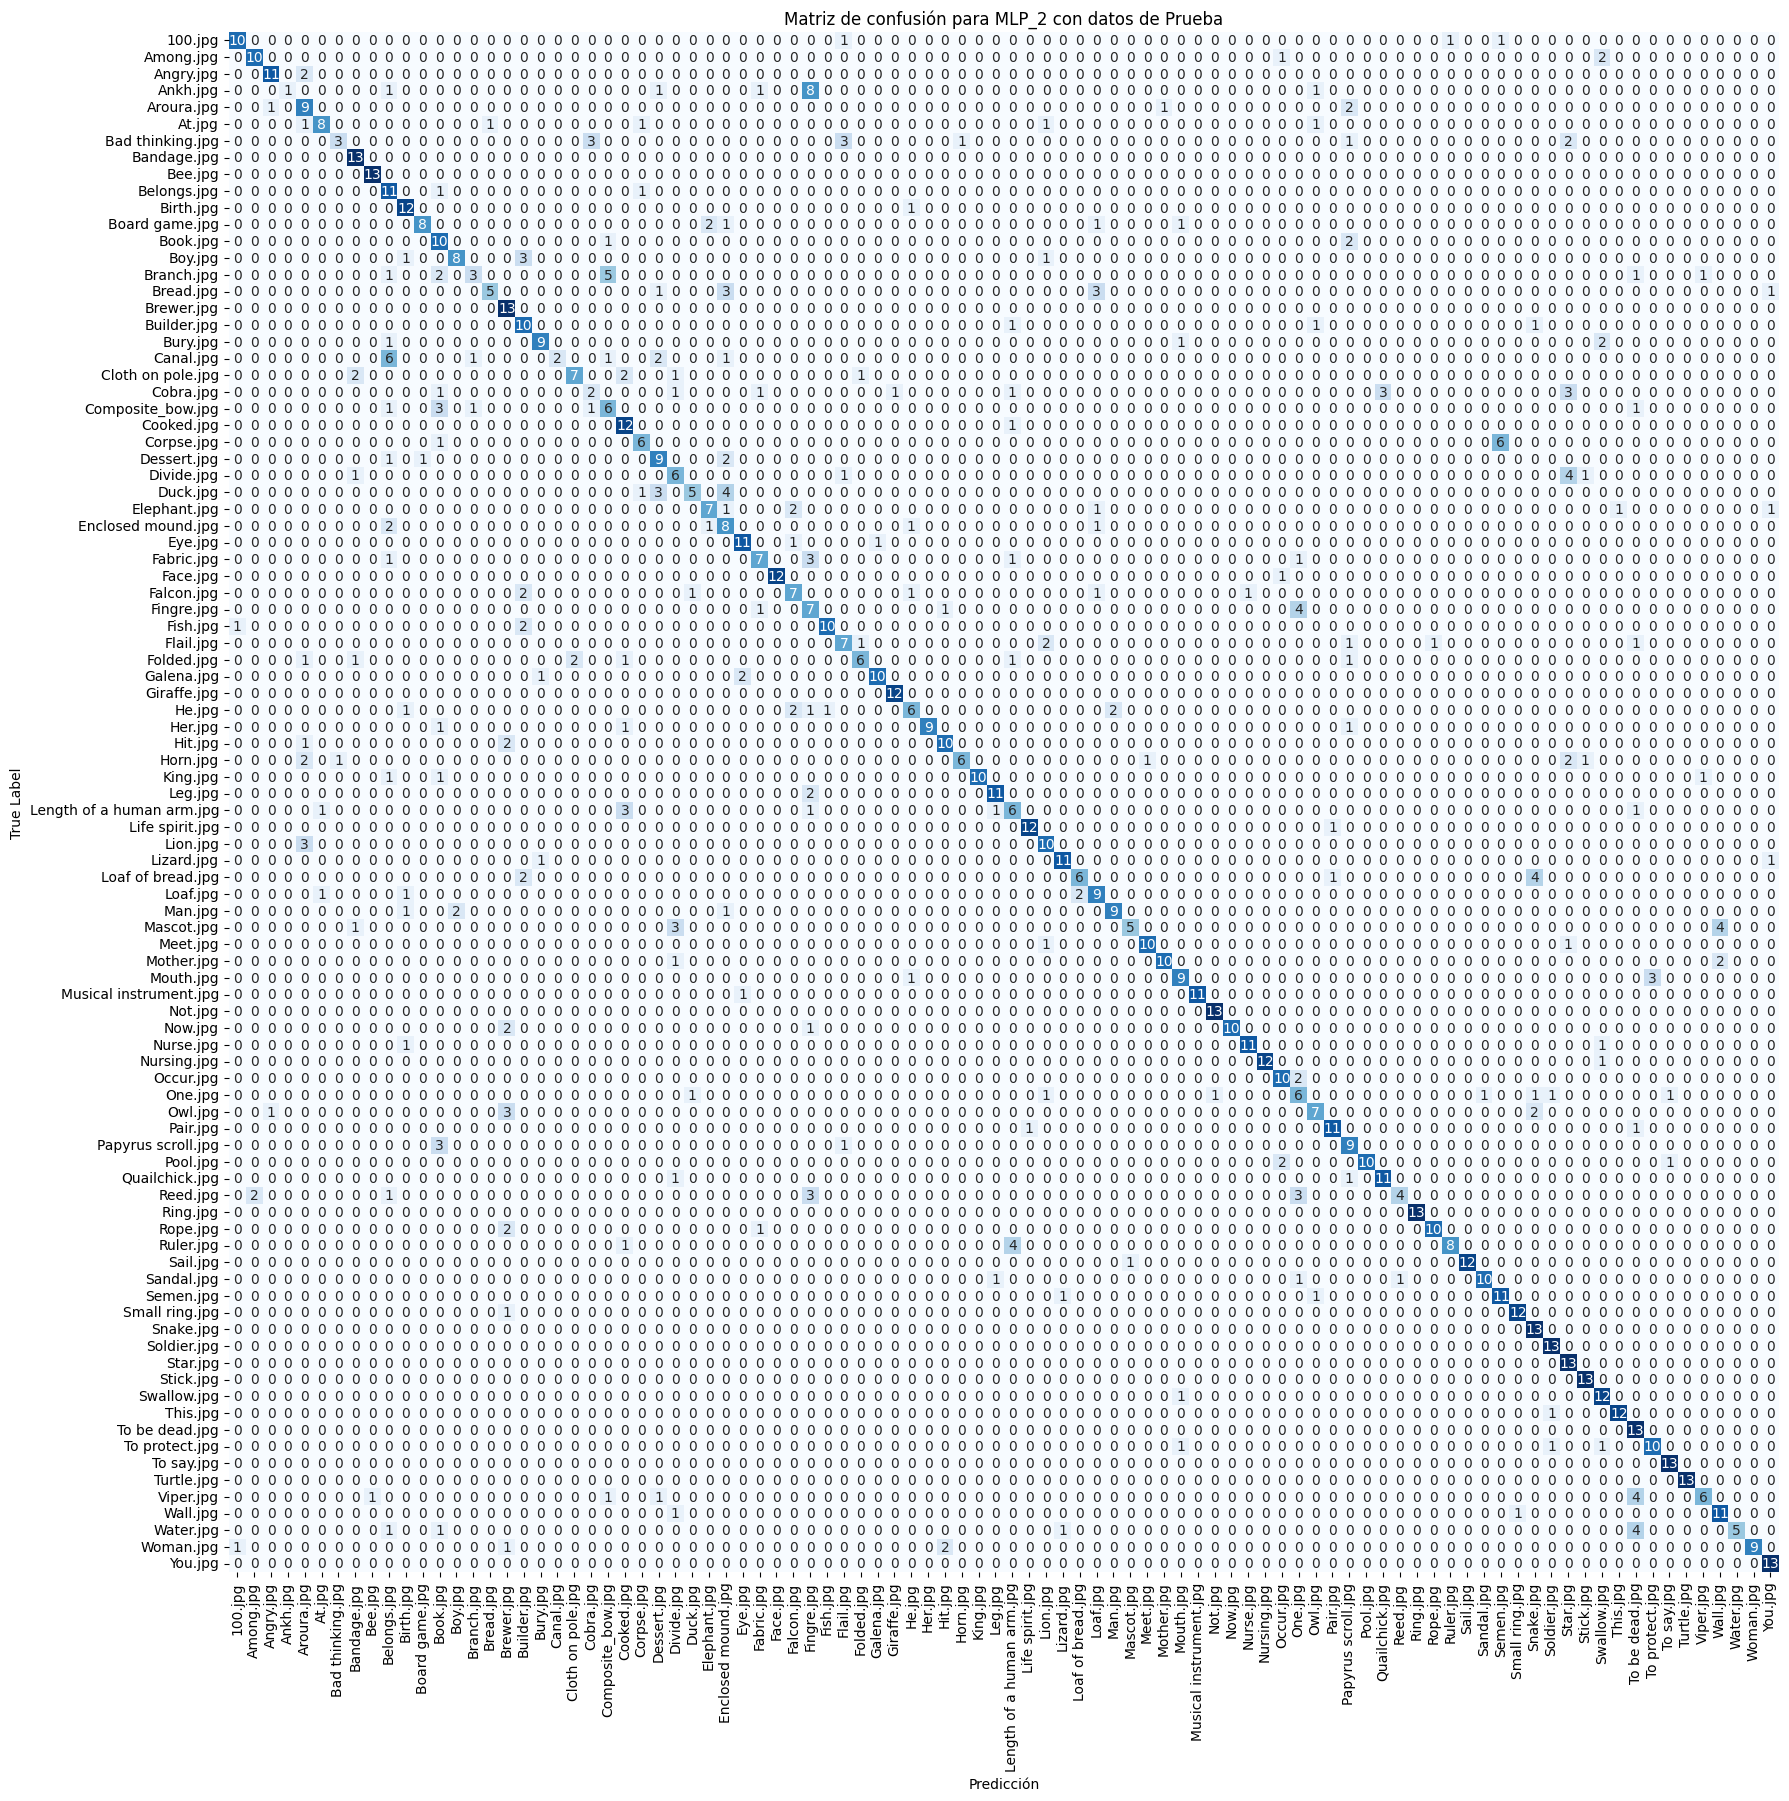

In [46]:
show_model_performance(x_test, y_test, mlp_2, "Prueba", list(training_category_counts.keys()))

#### 5.1.2 Tercer intento RNA MLP
Observando que el problema del overfit aun no se soluciona repetiremos el entrenamiento con la ultima arquitectura agregando una capa de Dropout, con un ratio de 0.3 antes de la última capa.

In [52]:
mlp_3_inputs = tf.keras.Input(shape=(128, 128, 1))
x = tf.keras.layers.Flatten()(mlp_3_inputs)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
mlp_3_outputs = tf.keras.layers.Dense(category_count, activation="softmax")(x)

mlp_3 = tf.keras.Model(inputs=mlp_3_inputs, outputs=mlp_3_outputs, name="MLP_3")

In [53]:
mlp_3.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [54]:
mlp_3.summary()

Model: "MLP_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 128, 128, 1)]     0         
                                                                 
 flatten_10 (Flatten)        (None, 16384)             0         
                                                                 
 dense_50 (Dense)            (None, 512)               8389120   
                                                                 
 dense_51 (Dense)            (None, 128)               65664     
                                                                 
 dense_52 (Dense)            (None, 64)                8256      
                                                                 
 dense_53 (Dense)            (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0     

In [55]:
mlp_3_history = mlp_3.fit(x_train, y_train, epochs=250,
                    validation_data=(x_validation, y_validation),
                    callbacks=[mlp_early_stopping])

Epoch 1/250
101/101 [==============================] - 5s 43ms/step - loss: 4.5272 - accuracy: 0.0093 - val_loss: 4.5213 - val_accuracy: 0.0139
Epoch 2/250
101/101 [==============================] - 4s 39ms/step - loss: 4.5220 - accuracy: 0.0074 - val_loss: 4.5190 - val_accuracy: 0.0028
Epoch 3/250
101/101 [==============================] - 4s 41ms/step - loss: 4.5187 - accuracy: 0.0133 - val_loss: 4.5155 - val_accuracy: 0.0000e+00
Epoch 4/250
101/101 [==============================] - 4s 44ms/step - loss: 4.5188 - accuracy: 0.0096 - val_loss: 4.5102 - val_accuracy: 0.0279
Epoch 5/250
101/101 [==============================] - 4s 42ms/step - loss: 4.5158 - accuracy: 0.0161 - val_loss: 4.5160 - val_accuracy: 0.0223
Epoch 6/250
101/101 [==============================] - 4s 41ms/step - loss: 4.5129 - accuracy: 0.0149 - val_loss: 4.4965 - val_accuracy: 0.0000e+00
Epoch 7/250
101/101 [==============================] - 5s 51ms/step - loss: 4.5053 - accuracy: 0.0133 - val_loss: 4.4864 - val_a

In [56]:
save_model(mlp_3)


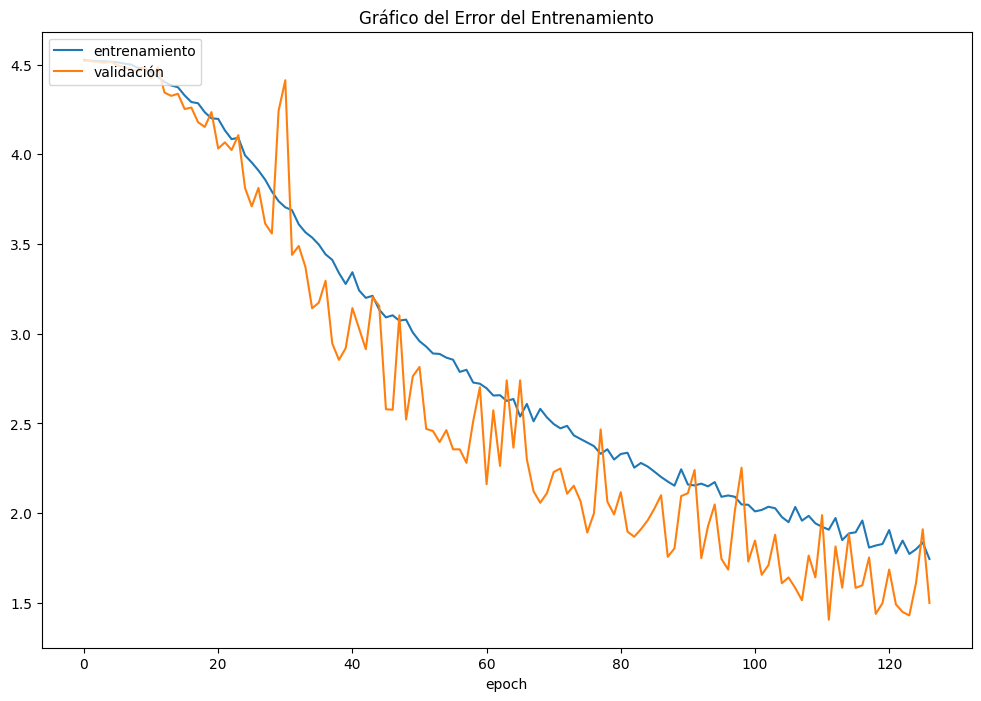

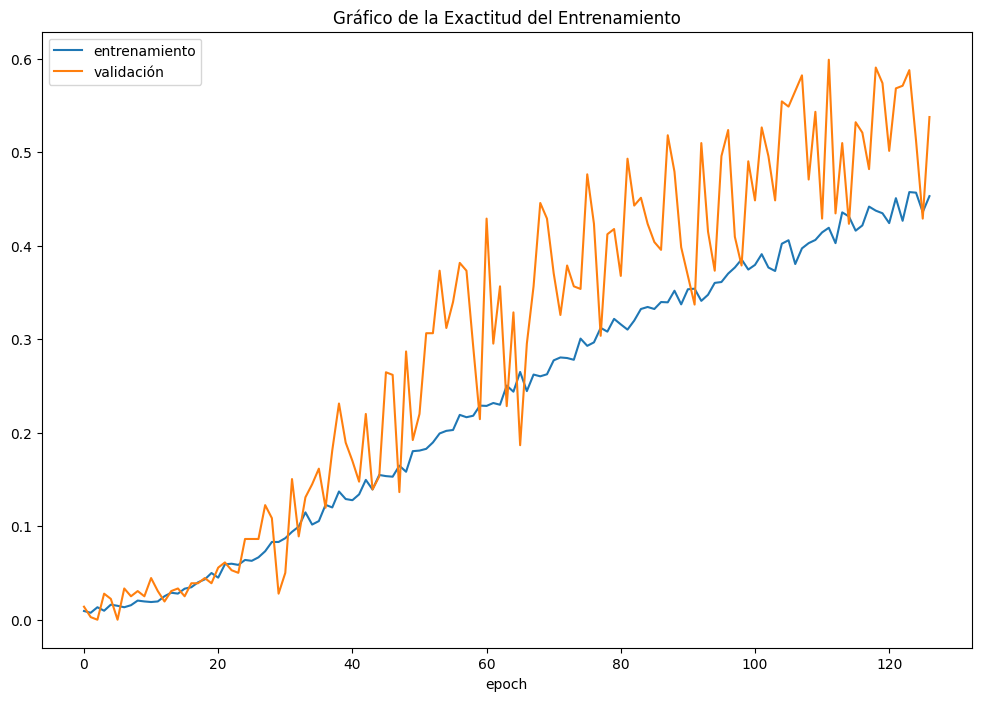

In [57]:
plot_training_history(mlp_3_history, (12,8))



 Reporte de Clasificación: 
                           precision    recall  f1-score   support

                  100.jpg       0.80      0.12      0.21        34
                Among.jpg       0.78      0.88      0.82        32
                Angry.jpg       0.89      0.76      0.82        33
                 Ankh.jpg       0.63      0.50      0.56        34
               Aroura.jpg       0.70      0.57      0.63        37
                   At.jpg       0.83      0.83      0.83        35
         Bad thinking.jpg       0.59      0.51      0.55        37
              Bandage.jpg       0.66      0.97      0.78        32
                  Bee.jpg       0.86      0.74      0.79        34
              Belongs.jpg       0.62      0.41      0.49        37
                Birth.jpg       0.67      0.86      0.75        35
           Board game.jpg       0.96      0.72      0.82        32
                 Book.jpg       0.45      0.58      0.51        33
                  Boy.jpg       

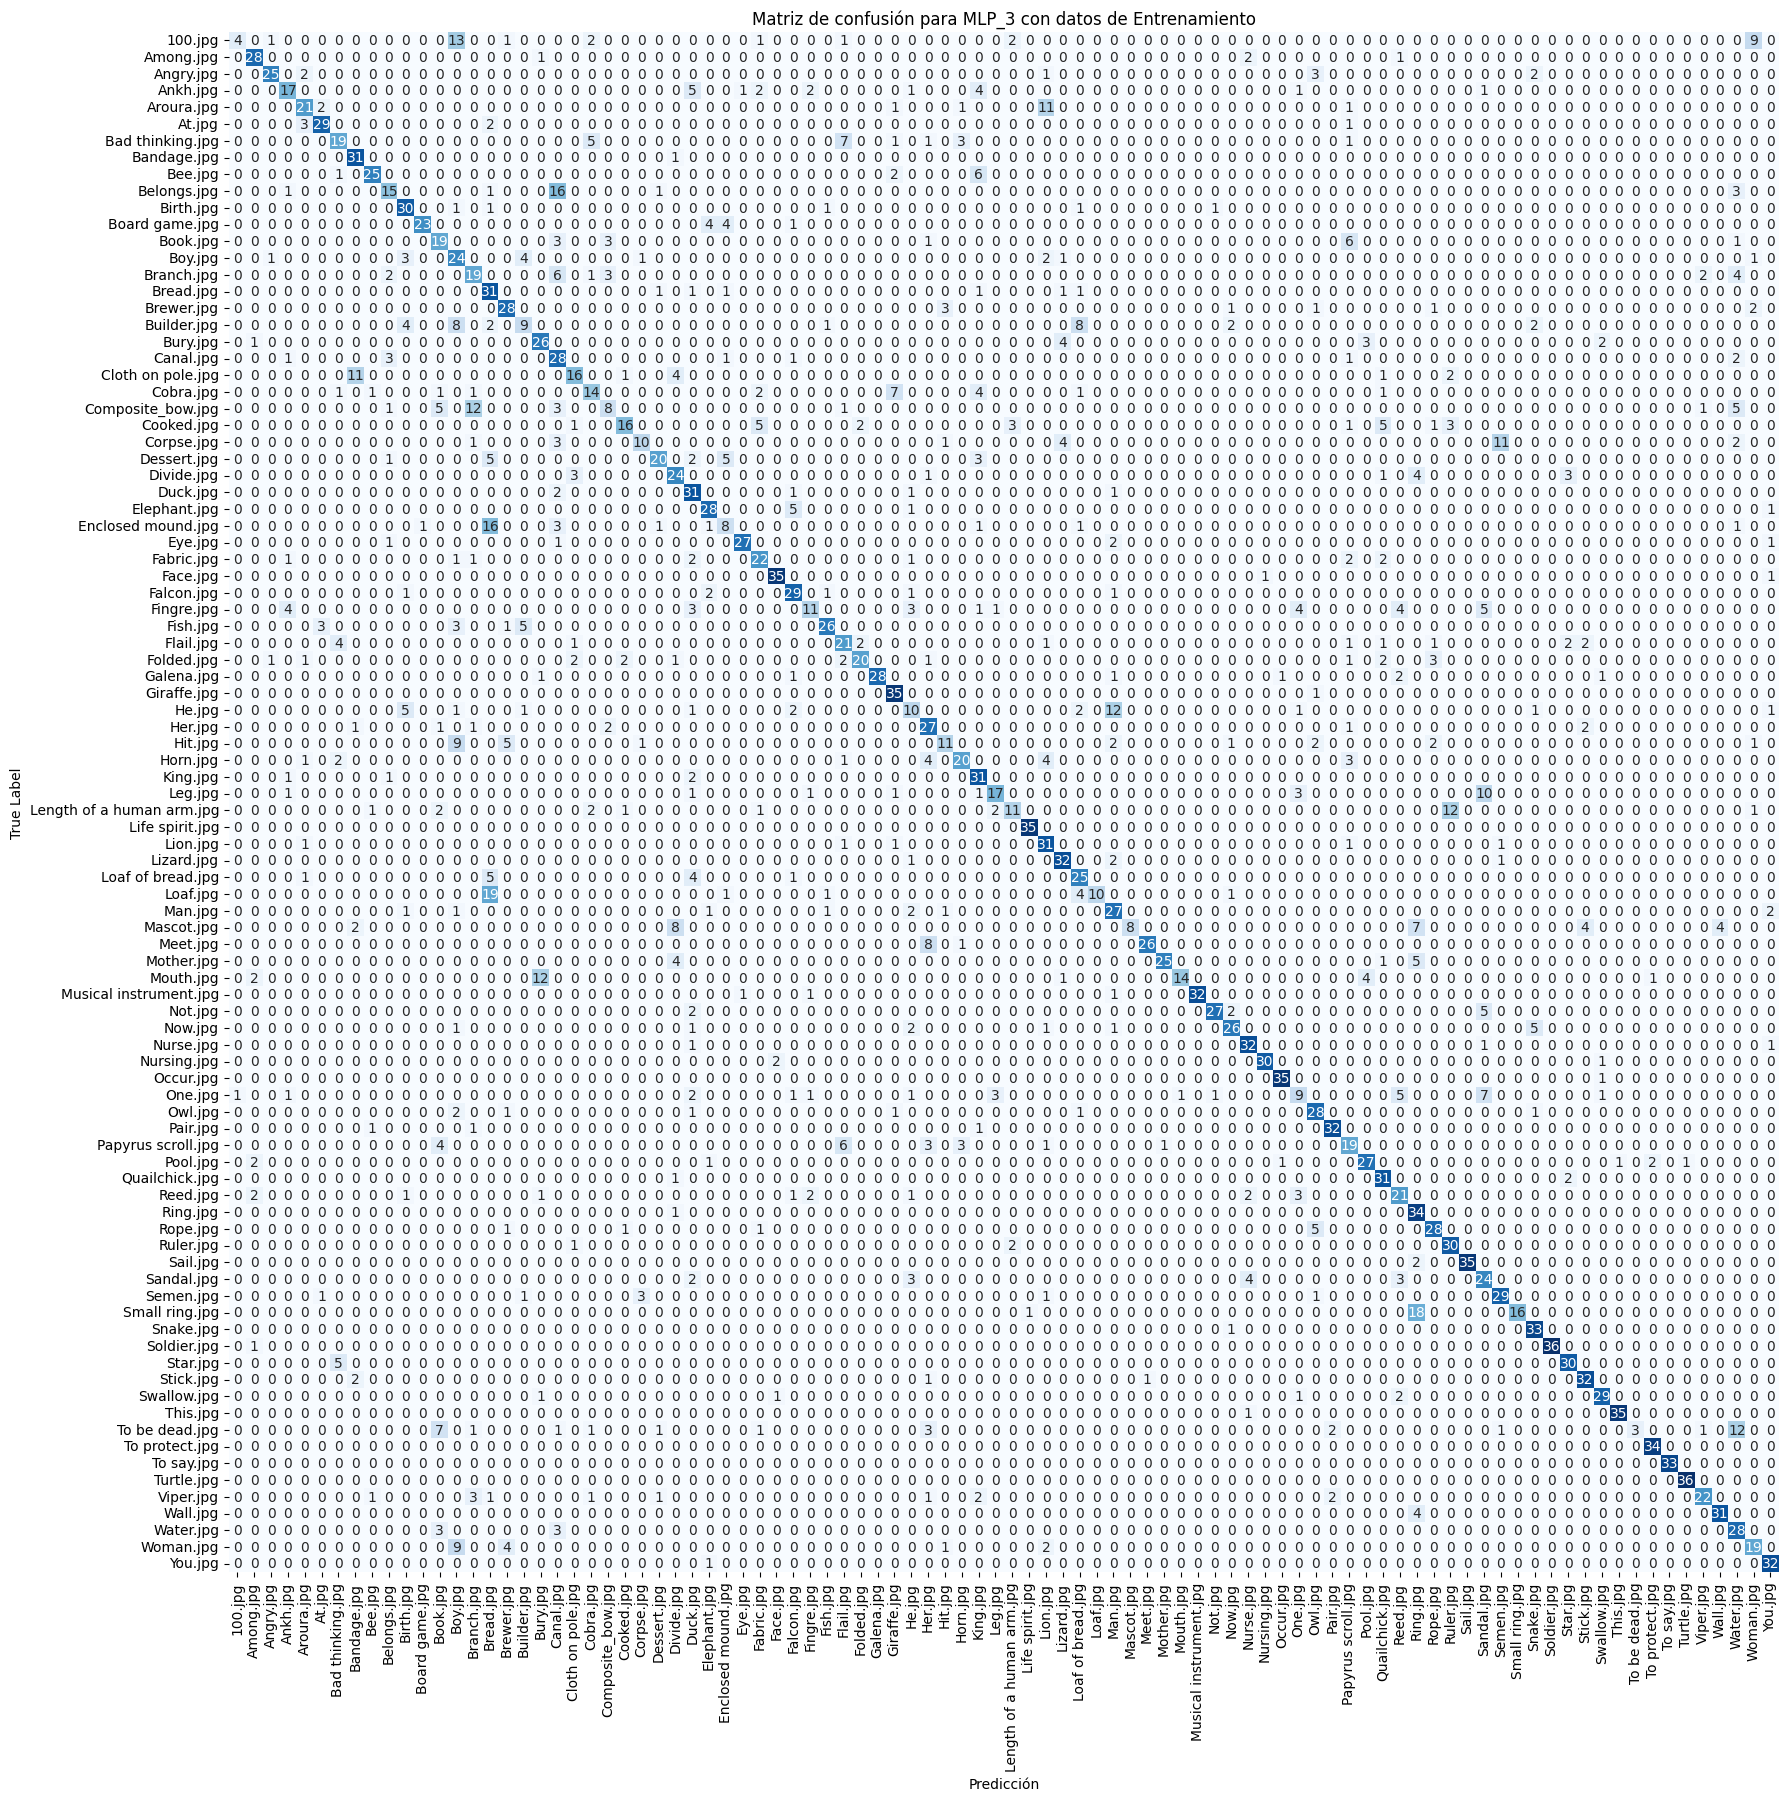

In [58]:
show_model_performance(x_train, y_train, mlp_3, "Entrenamiento", list(training_category_counts.keys()))


 Reporte de Clasificación: 
                           precision    recall  f1-score   support

                  100.jpg       1.00      0.38      0.56        13
                Among.jpg       0.72      1.00      0.84        13
                Angry.jpg       0.91      0.77      0.83        13
                 Ankh.jpg       0.56      0.38      0.45        13
               Aroura.jpg       0.38      0.38      0.38        13
                   At.jpg       0.80      0.62      0.70        13
         Bad thinking.jpg       0.33      0.38      0.36        13
              Bandage.jpg       0.76      1.00      0.87        13
                  Bee.jpg       0.75      0.92      0.83        13
              Belongs.jpg       1.00      0.15      0.27        13
                Birth.jpg       0.62      1.00      0.76        13
           Board game.jpg       1.00      0.38      0.56        13
                 Book.jpg       0.44      0.62      0.52        13
                  Boy.jpg       

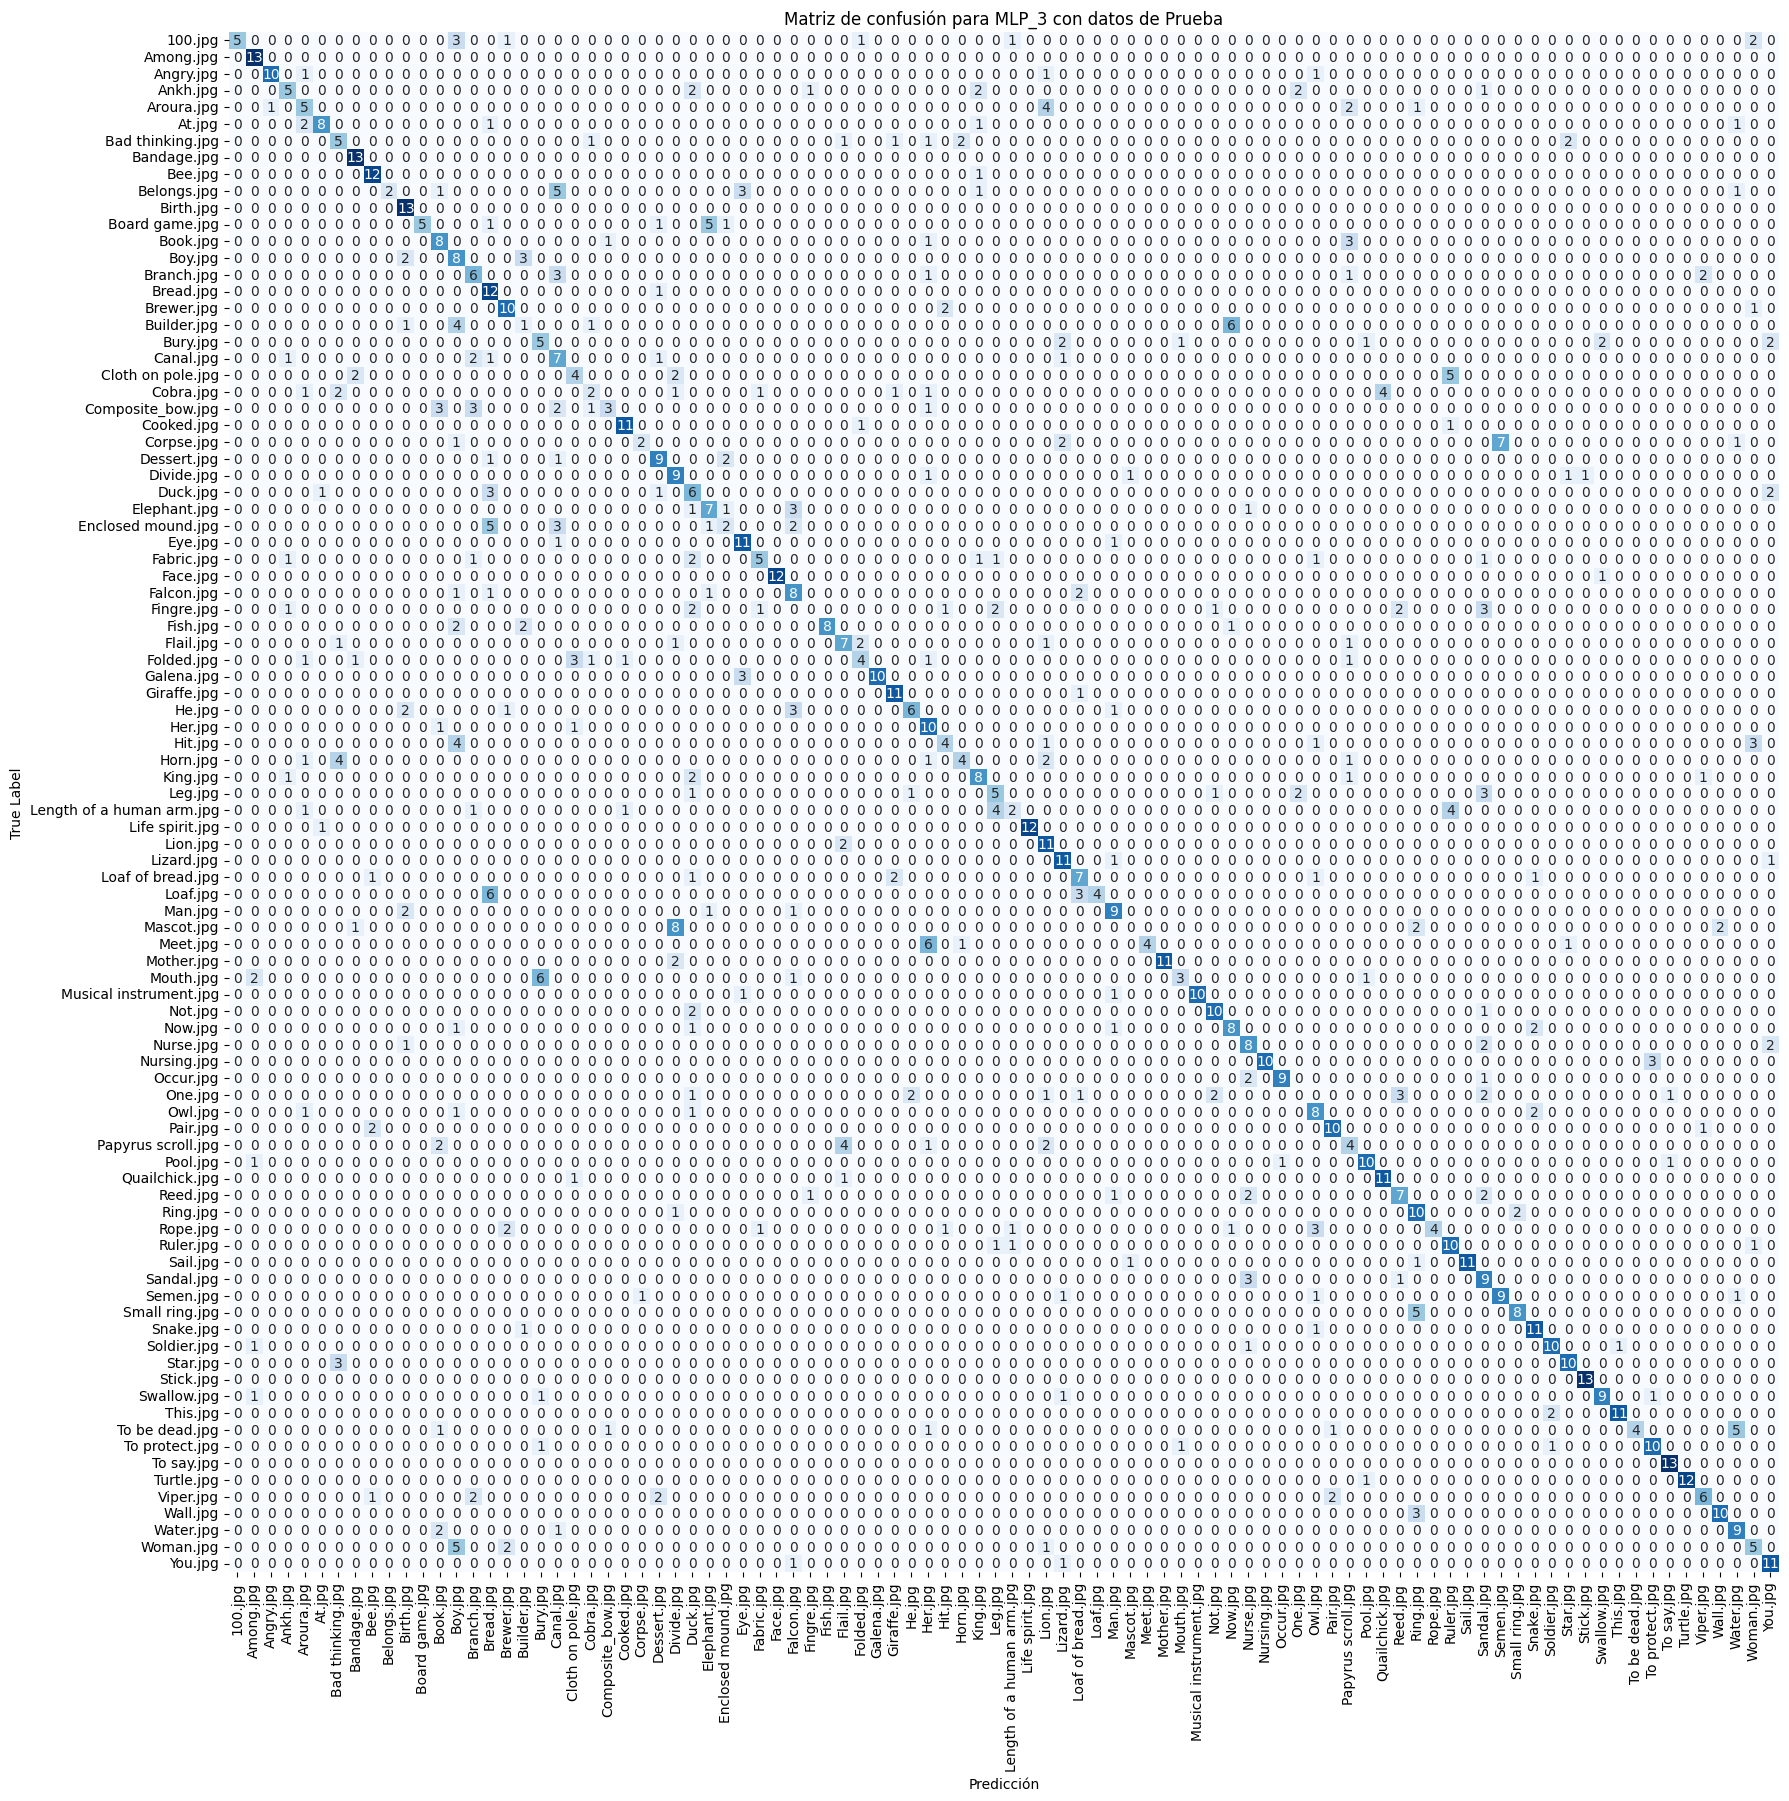

In [59]:
show_model_performance(x_test, y_test, mlp_3, "Prueba", list(training_category_counts.keys()))

### 5.2 Red Neuronal Convolucional (CNN)

#### 5.2.1 Primer intento CNN
La primera red neuronal convolucional a utilizar recibe las imágenes de 128x128 píxeles con un canal (128,128,1) y las procesa utilizando tres grupos de capas convolucionales. Cada grupo esta formado por una capa convolucional, con 32, 64 y 128 filtros respectivamente, seguida de una capa de MaxPooling con tamaño 2x2 en todos los casos. Los resultados de la última capa convolucional son aplanadas y pasadas por una capa densa de 128 neuronas con activación ReLU. Finalmente, la capa de salida es una capa densa con 92 neuronas (la cantidad de categorías exisntentes) que utiliza una activación softmax para la clasificación. 

El modelo es entrenado con el optimizador Adam, con su valor de Learning Rate por defecto (0.001). Para los calculos de error se utiliza "categorical_crossentropy". El número de épocas durante las que se entrenará es de 100, pero se añadó un Callback de Early Stopping al modelo, con una paciencia de 10 épocas, que detiene el entrenamiento si no hay mejoras. El batch size a utilizar también es el valor por defecto definido por keras (32)

In [18]:
cnn_1_inputs = tf.keras.Input(shape=(128, 128, 1))
x = tf.keras.layers.Conv2D(32, 3, activation="relu")(cnn_1_inputs)
x = tf.keras.layers.MaxPooling2D((2,2))(x)

x = tf.keras.layers.Conv2D(64, 3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)

x = tf.keras.layers.Conv2D(128, 3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
cnn_1_outputs = tf.keras.layers.Dense(category_count, activation="softmax")(x)

cnn_1 = Model(inputs=cnn_1_inputs, outputs=cnn_1_outputs, name = "CNN_1")

In [19]:
cnn_early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

In [20]:
cnn_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
cnn_1.summary()

Model: "CNN_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856 

In [22]:
cnn_1_history = cnn_1.fit(x_train, y_train, epochs=100,
                          validation_data=(x_validation, y_validation),
                          callbacks=[cnn_early_stopping])

Epoch 1/100
101/101 [==============================] - 11s 101ms/step - loss: 4.2834 - accuracy: 0.0487 - val_loss: 3.2192 - val_accuracy: 0.2340
Epoch 2/100
101/101 [==============================] - 10s 94ms/step - loss: 1.8118 - accuracy: 0.5216 - val_loss: 1.0478 - val_accuracy: 0.7131
Epoch 3/100
101/101 [==============================] - 10s 95ms/step - loss: 0.6253 - accuracy: 0.8247 - val_loss: 0.6601 - val_accuracy: 0.7994
Epoch 4/100
101/101 [==============================] - 10s 95ms/step - loss: 0.2843 - accuracy: 0.9209 - val_loss: 0.6758 - val_accuracy: 0.8106
Epoch 5/100
101/101 [==============================] - 10s 96ms/step - loss: 0.1753 - accuracy: 0.9519 - val_loss: 0.4997 - val_accuracy: 0.8747
Epoch 6/100
101/101 [==============================] - 10s 97ms/step - loss: 0.0823 - accuracy: 0.9774 - val_loss: 0.4569 - val_accuracy: 0.8914
Epoch 7/100
101/101 [==============================] - 10s 98ms/step - loss: 0.0403 - accuracy: 0.9922 - val_loss: 0.4548 - val_a

In [23]:
save_model(cnn_1)
cnn_1.evaluate(x_test, y_test)

38/38 [==============================] - 1s 25ms/step - loss: 0.5182 - accuracy: 0.8899


[0.5181702971458435, 0.889915943145752]

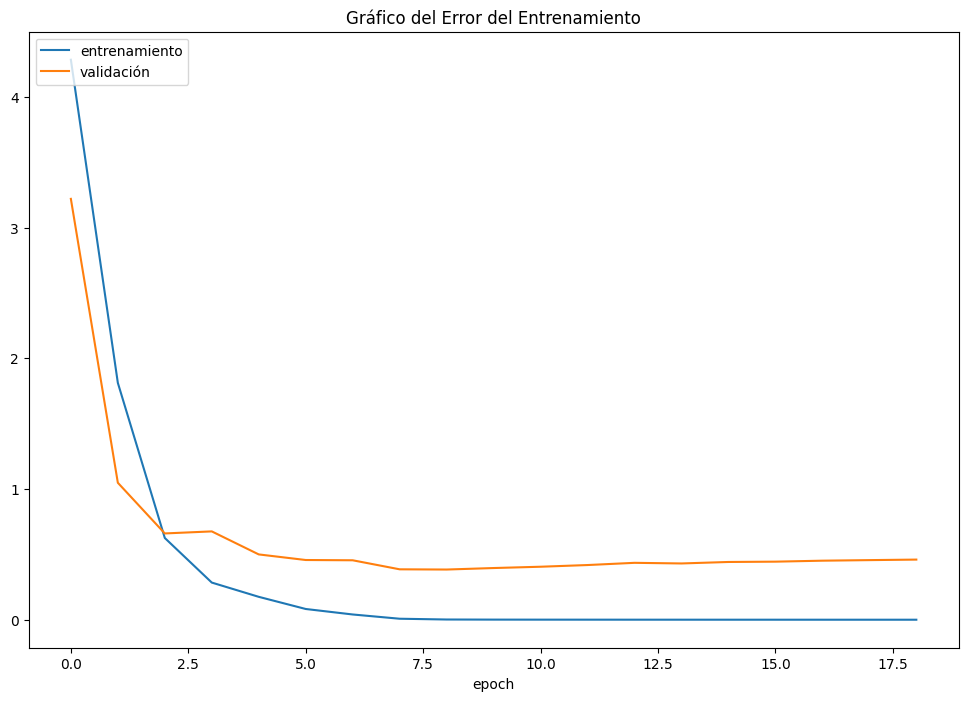

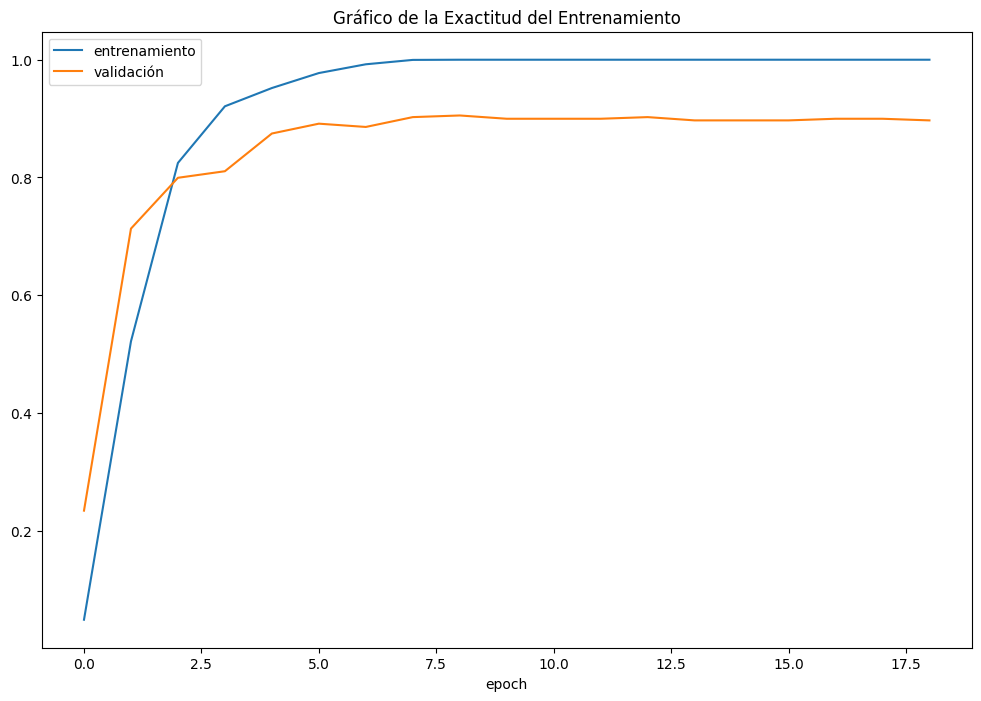

In [27]:
plot_training_history(cnn_1_history, (12,8))


 Reporte de Clasificación: 
                           precision    recall  f1-score   support

                  100.jpg       1.00      1.00      1.00        38
                Among.jpg       1.00      1.00      1.00        37
                Angry.jpg       1.00      1.00      1.00        34
                 Ankh.jpg       1.00      1.00      1.00        35
               Aroura.jpg       1.00      1.00      1.00        37
                   At.jpg       1.00      1.00      1.00        36
         Bad thinking.jpg       1.00      1.00      1.00        36
              Bandage.jpg       1.00      1.00      1.00        37
                  Bee.jpg       1.00      1.00      1.00        35
              Belongs.jpg       1.00      1.00      1.00        32
                Birth.jpg       1.00      1.00      1.00        33
           Board game.jpg       1.00      1.00      1.00        35
                 Book.jpg       1.00      1.00      1.00        38
                  Boy.jpg       

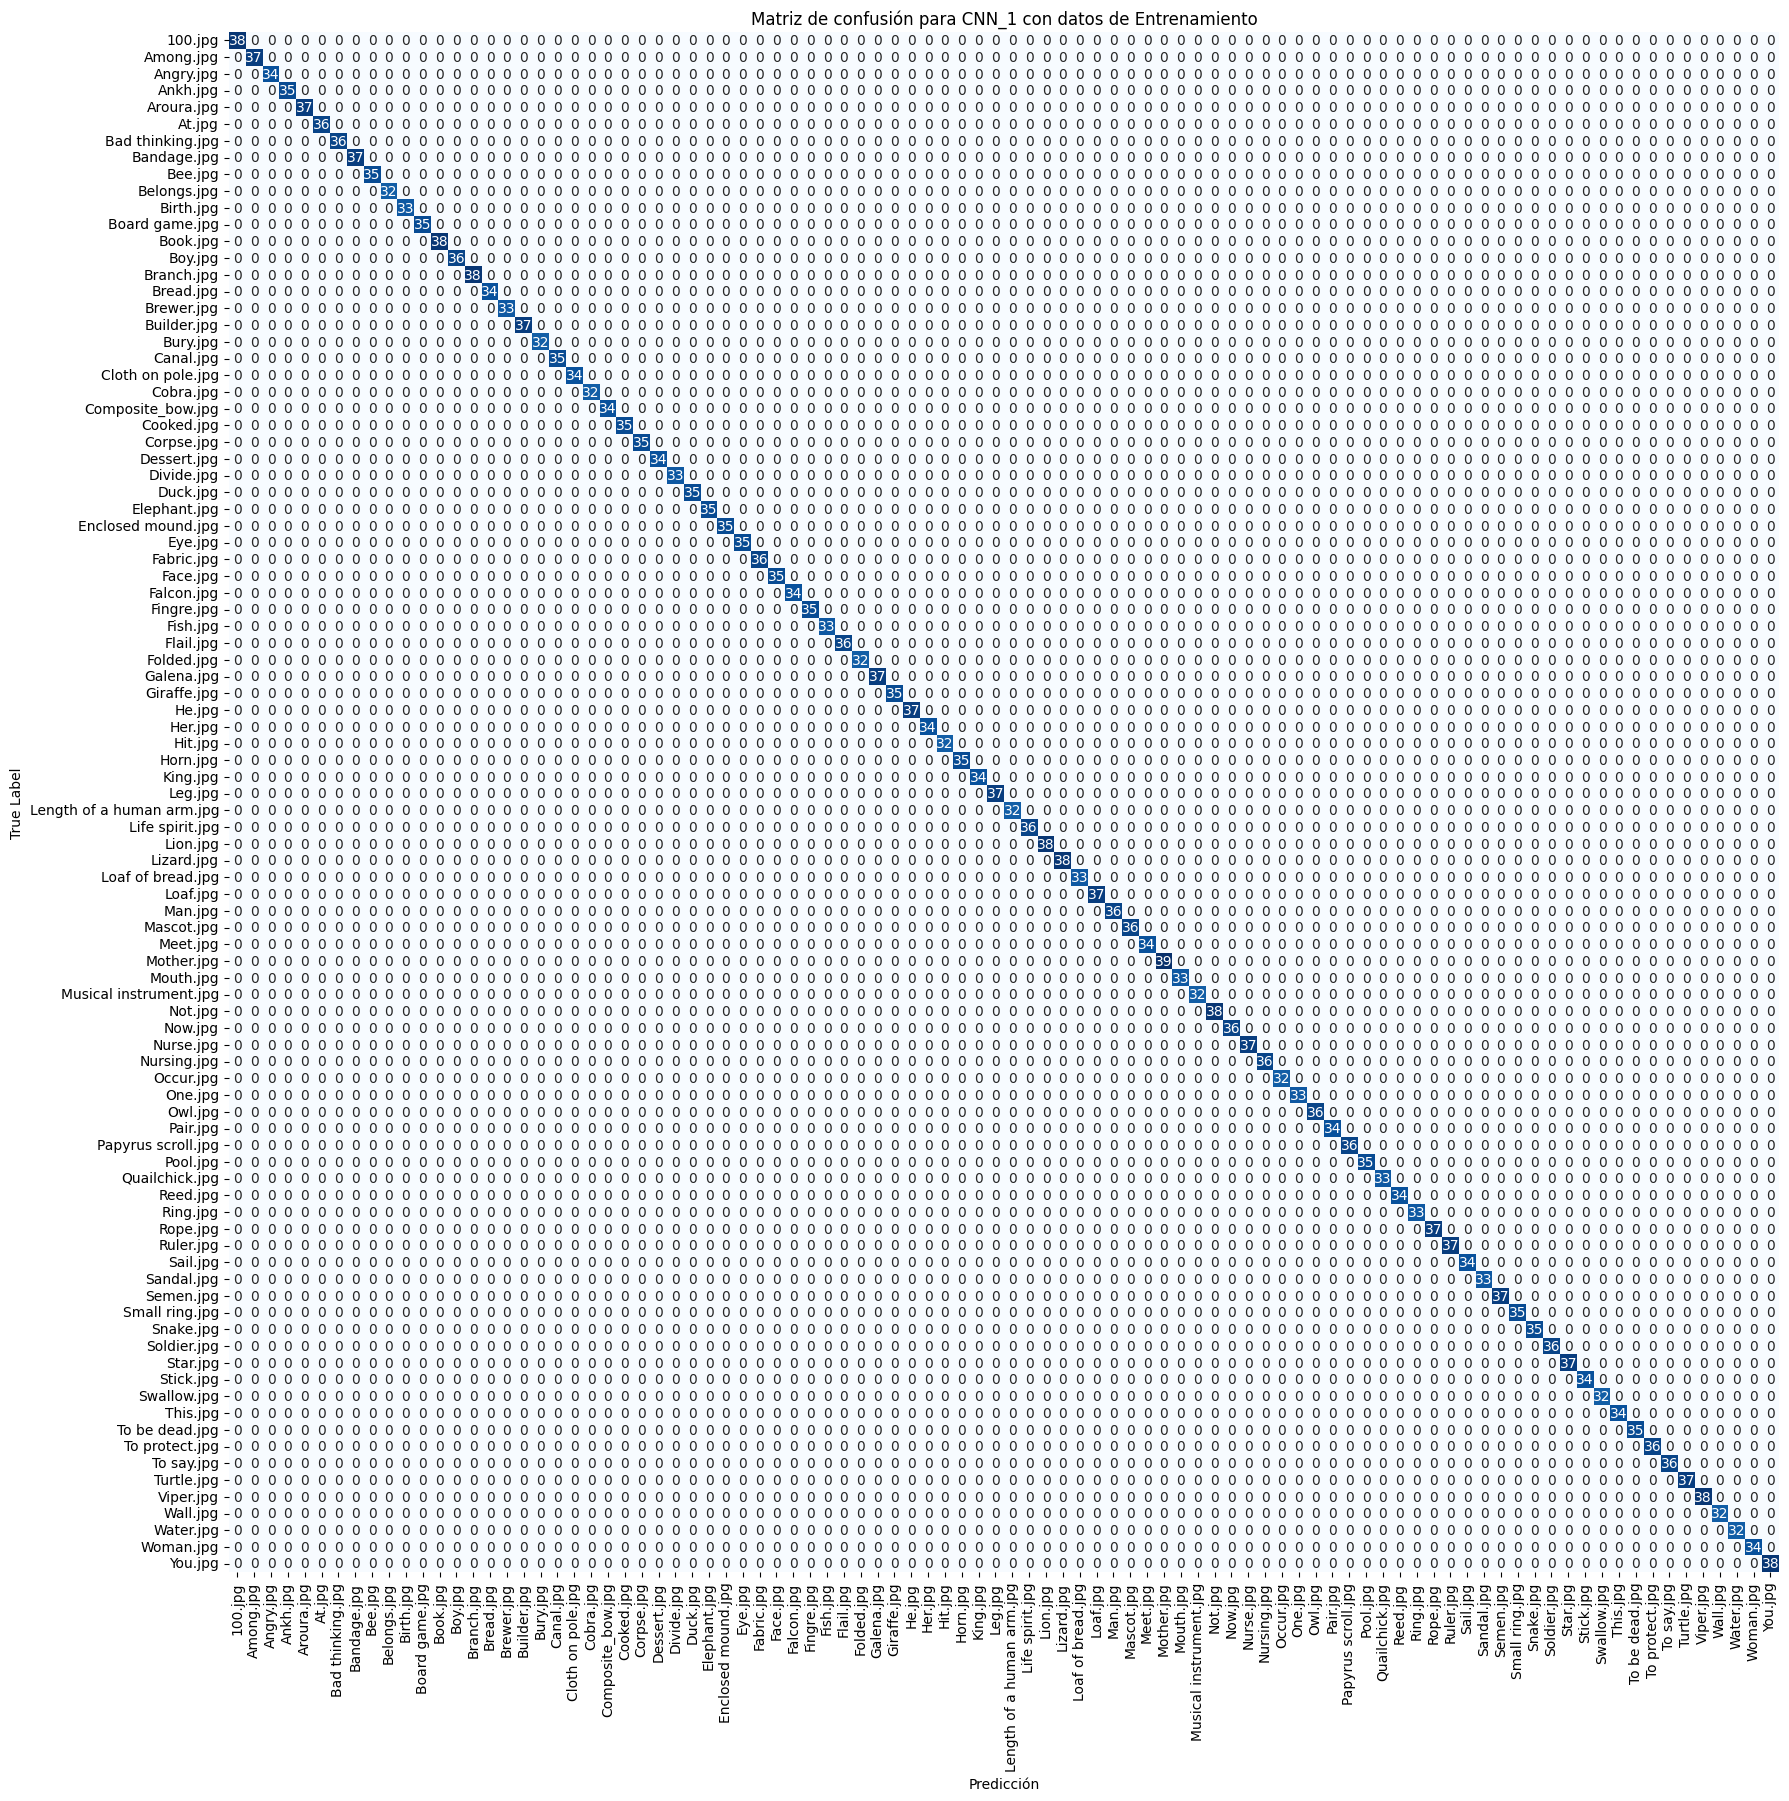

In [28]:
show_model_performance(x_train, y_train, cnn_1, "Entrenamiento", list(training_category_counts.keys()))


 Reporte de Clasificación: 
                           precision    recall  f1-score   support

                  100.jpg       0.87      1.00      0.93        13
                Among.jpg       0.93      1.00      0.96        13
                Angry.jpg       0.92      0.92      0.92        13
                 Ankh.jpg       1.00      1.00      1.00        13
               Aroura.jpg       1.00      0.77      0.87        13
                   At.jpg       0.92      0.85      0.88        13
         Bad thinking.jpg       0.92      0.85      0.88        13
              Bandage.jpg       0.87      1.00      0.93        13
                  Bee.jpg       1.00      0.92      0.96        13
              Belongs.jpg       0.85      0.85      0.85        13
                Birth.jpg       0.92      0.92      0.92        13
           Board game.jpg       1.00      0.92      0.96        13
                 Book.jpg       0.92      0.85      0.88        13
                  Boy.jpg       

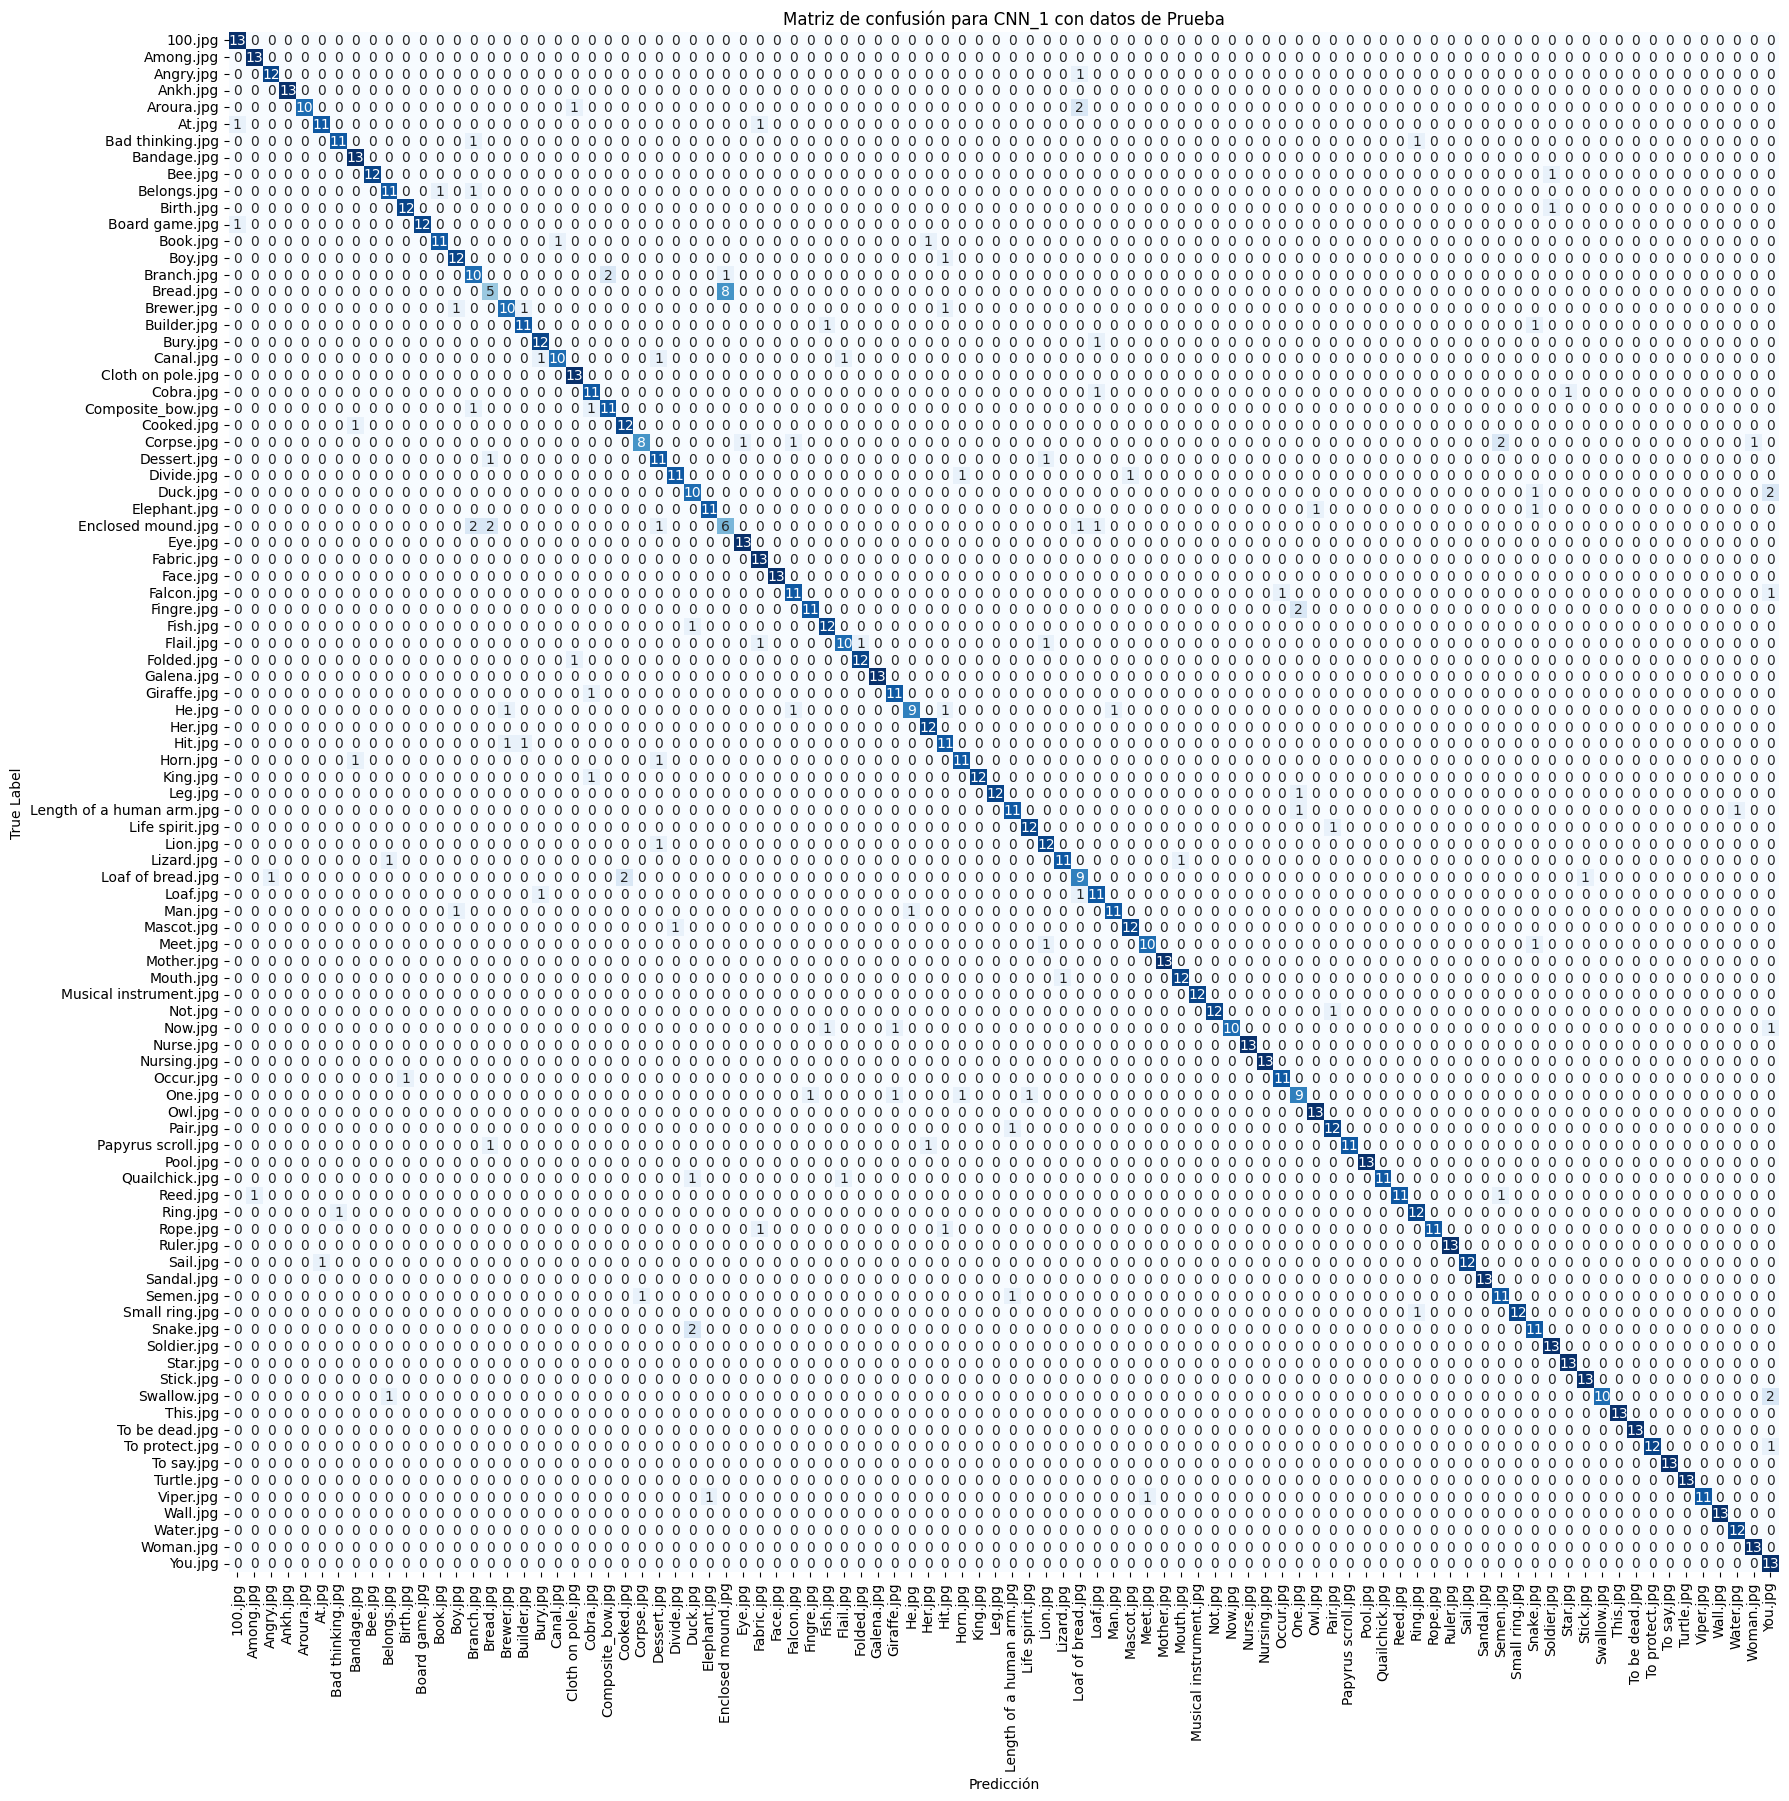

In [29]:
show_model_performance(x_test, y_test, cnn_1, "Prueba", list(training_category_counts.keys()))

#### 5.2.2 Segundo intento CNN
Analizando los resultados de la primera iteración de la CNN, se observa que la red alcanza valores muy altos de exactitud y errores bajos para los datos de entrenamiento a medida que avanzan las épocas. Sin embargo, el rendimiento empeora en los datos de validación y prueba, lo que indica que el modelo está experimentando overfitting. A pesar de esto, la diferencia en el rendimiento no es tan significativa, por lo que en este segundo intento se utilizará la misma configuración de la red, con una pequeña modificación: se añadirá una capa Dropout con un rate de 0.5 antes de la última capa, con el objetivo de evitar el problema de overfitting

In [30]:
cnn_2_inputs = tf.keras.Input(shape=(128, 128, 1))
x = tf.keras.layers.Conv2D(32, 3, activation="relu")(cnn_2_inputs)
x = tf.keras.layers.MaxPooling2D((2,2))(x)

x = tf.keras.layers.Conv2D(64, 3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)

x = tf.keras.layers.Conv2D(128, 3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
cnn_2_outputs = tf.keras.layers.Dense(category_count, activation="softmax")(x)

cnn_2 = Model(inputs=cnn_2_inputs, outputs=cnn_2_outputs, name = "CNN_2")

In [31]:
cnn_2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

cnn_2.summary()

Model: "CNN_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       73856 

In [32]:
cnn_2_history = cnn_2.fit(x_train, y_train, epochs=100,
                          validation_data=(x_validation, y_validation),
                          callbacks=[cnn_early_stopping])

Epoch 1/100
101/101 [==============================] - 11s 97ms/step - loss: 4.4752 - accuracy: 0.0152 - val_loss: 4.0516 - val_accuracy: 0.0864
Epoch 2/100
101/101 [==============================] - 9s 91ms/step - loss: 3.5270 - accuracy: 0.1573 - val_loss: 2.3047 - val_accuracy: 0.4735
Epoch 3/100
101/101 [==============================] - 9s 93ms/step - loss: 2.2066 - accuracy: 0.4145 - val_loss: 1.2449 - val_accuracy: 0.6602
Epoch 4/100
101/101 [==============================] - 9s 92ms/step - loss: 1.5604 - accuracy: 0.5585 - val_loss: 0.9429 - val_accuracy: 0.7772
Epoch 5/100
101/101 [==============================] - 9s 91ms/step - loss: 1.0535 - accuracy: 0.6907 - val_loss: 0.6048 - val_accuracy: 0.8468
Epoch 6/100
101/101 [==============================] - 9s 92ms/step - loss: 0.8214 - accuracy: 0.7530 - val_loss: 0.5540 - val_accuracy: 0.8830
Epoch 7/100
101/101 [==============================] - 9s 92ms/step - loss: 0.6470 - accuracy: 0.8048 - val_loss: 0.4229 - val_accuracy

In [33]:
save_model(cnn_2)
cnn_2.evaluate(x_test, y_test)

38/38 [==============================] - 1s 25ms/step - loss: 0.2164 - accuracy: 0.9462


[0.21641281247138977, 0.9462184906005859]

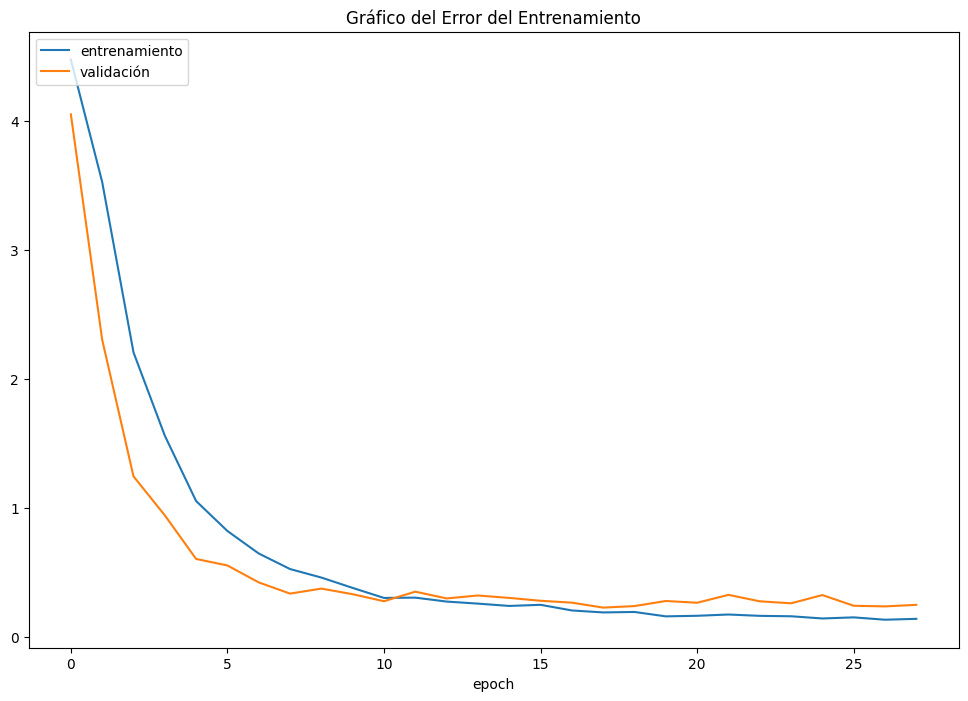

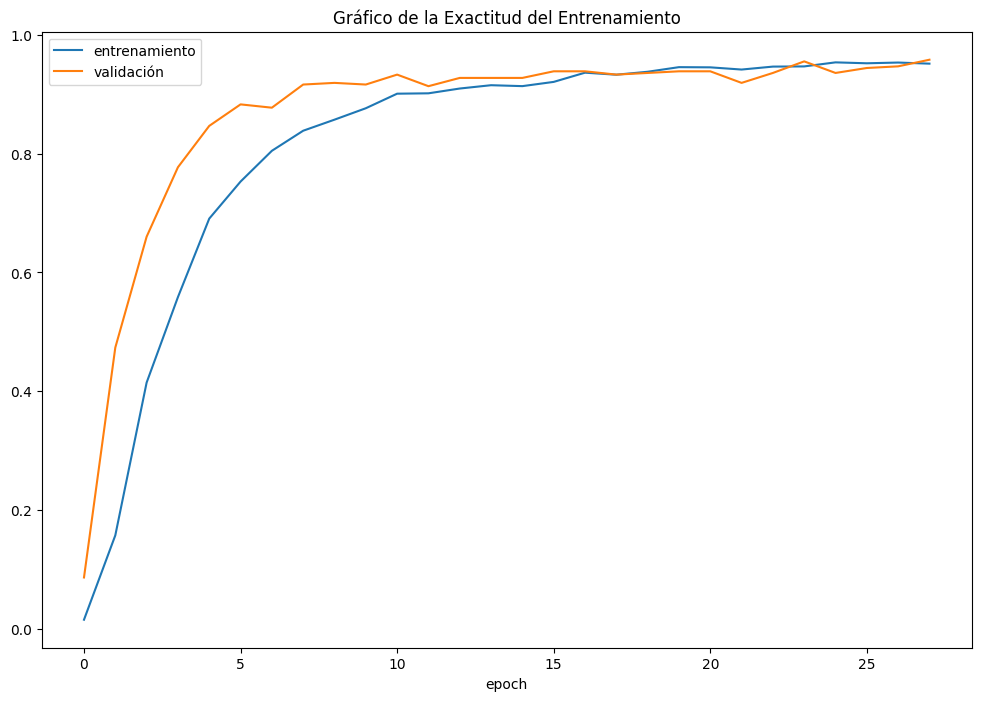

In [34]:
plot_training_history(cnn_2_history, (12,8))


 Reporte de Clasificación: 
                           precision    recall  f1-score   support

                  100.jpg       1.00      1.00      1.00        38
                Among.jpg       1.00      1.00      1.00        37
                Angry.jpg       1.00      1.00      1.00        34
                 Ankh.jpg       1.00      1.00      1.00        35
               Aroura.jpg       1.00      1.00      1.00        37
                   At.jpg       1.00      1.00      1.00        36
         Bad thinking.jpg       1.00      1.00      1.00        36
              Bandage.jpg       1.00      1.00      1.00        37
                  Bee.jpg       1.00      1.00      1.00        35
              Belongs.jpg       1.00      1.00      1.00        32
                Birth.jpg       1.00      1.00      1.00        33
           Board game.jpg       1.00      1.00      1.00        35
                 Book.jpg       1.00      1.00      1.00        38
                  Boy.jpg       

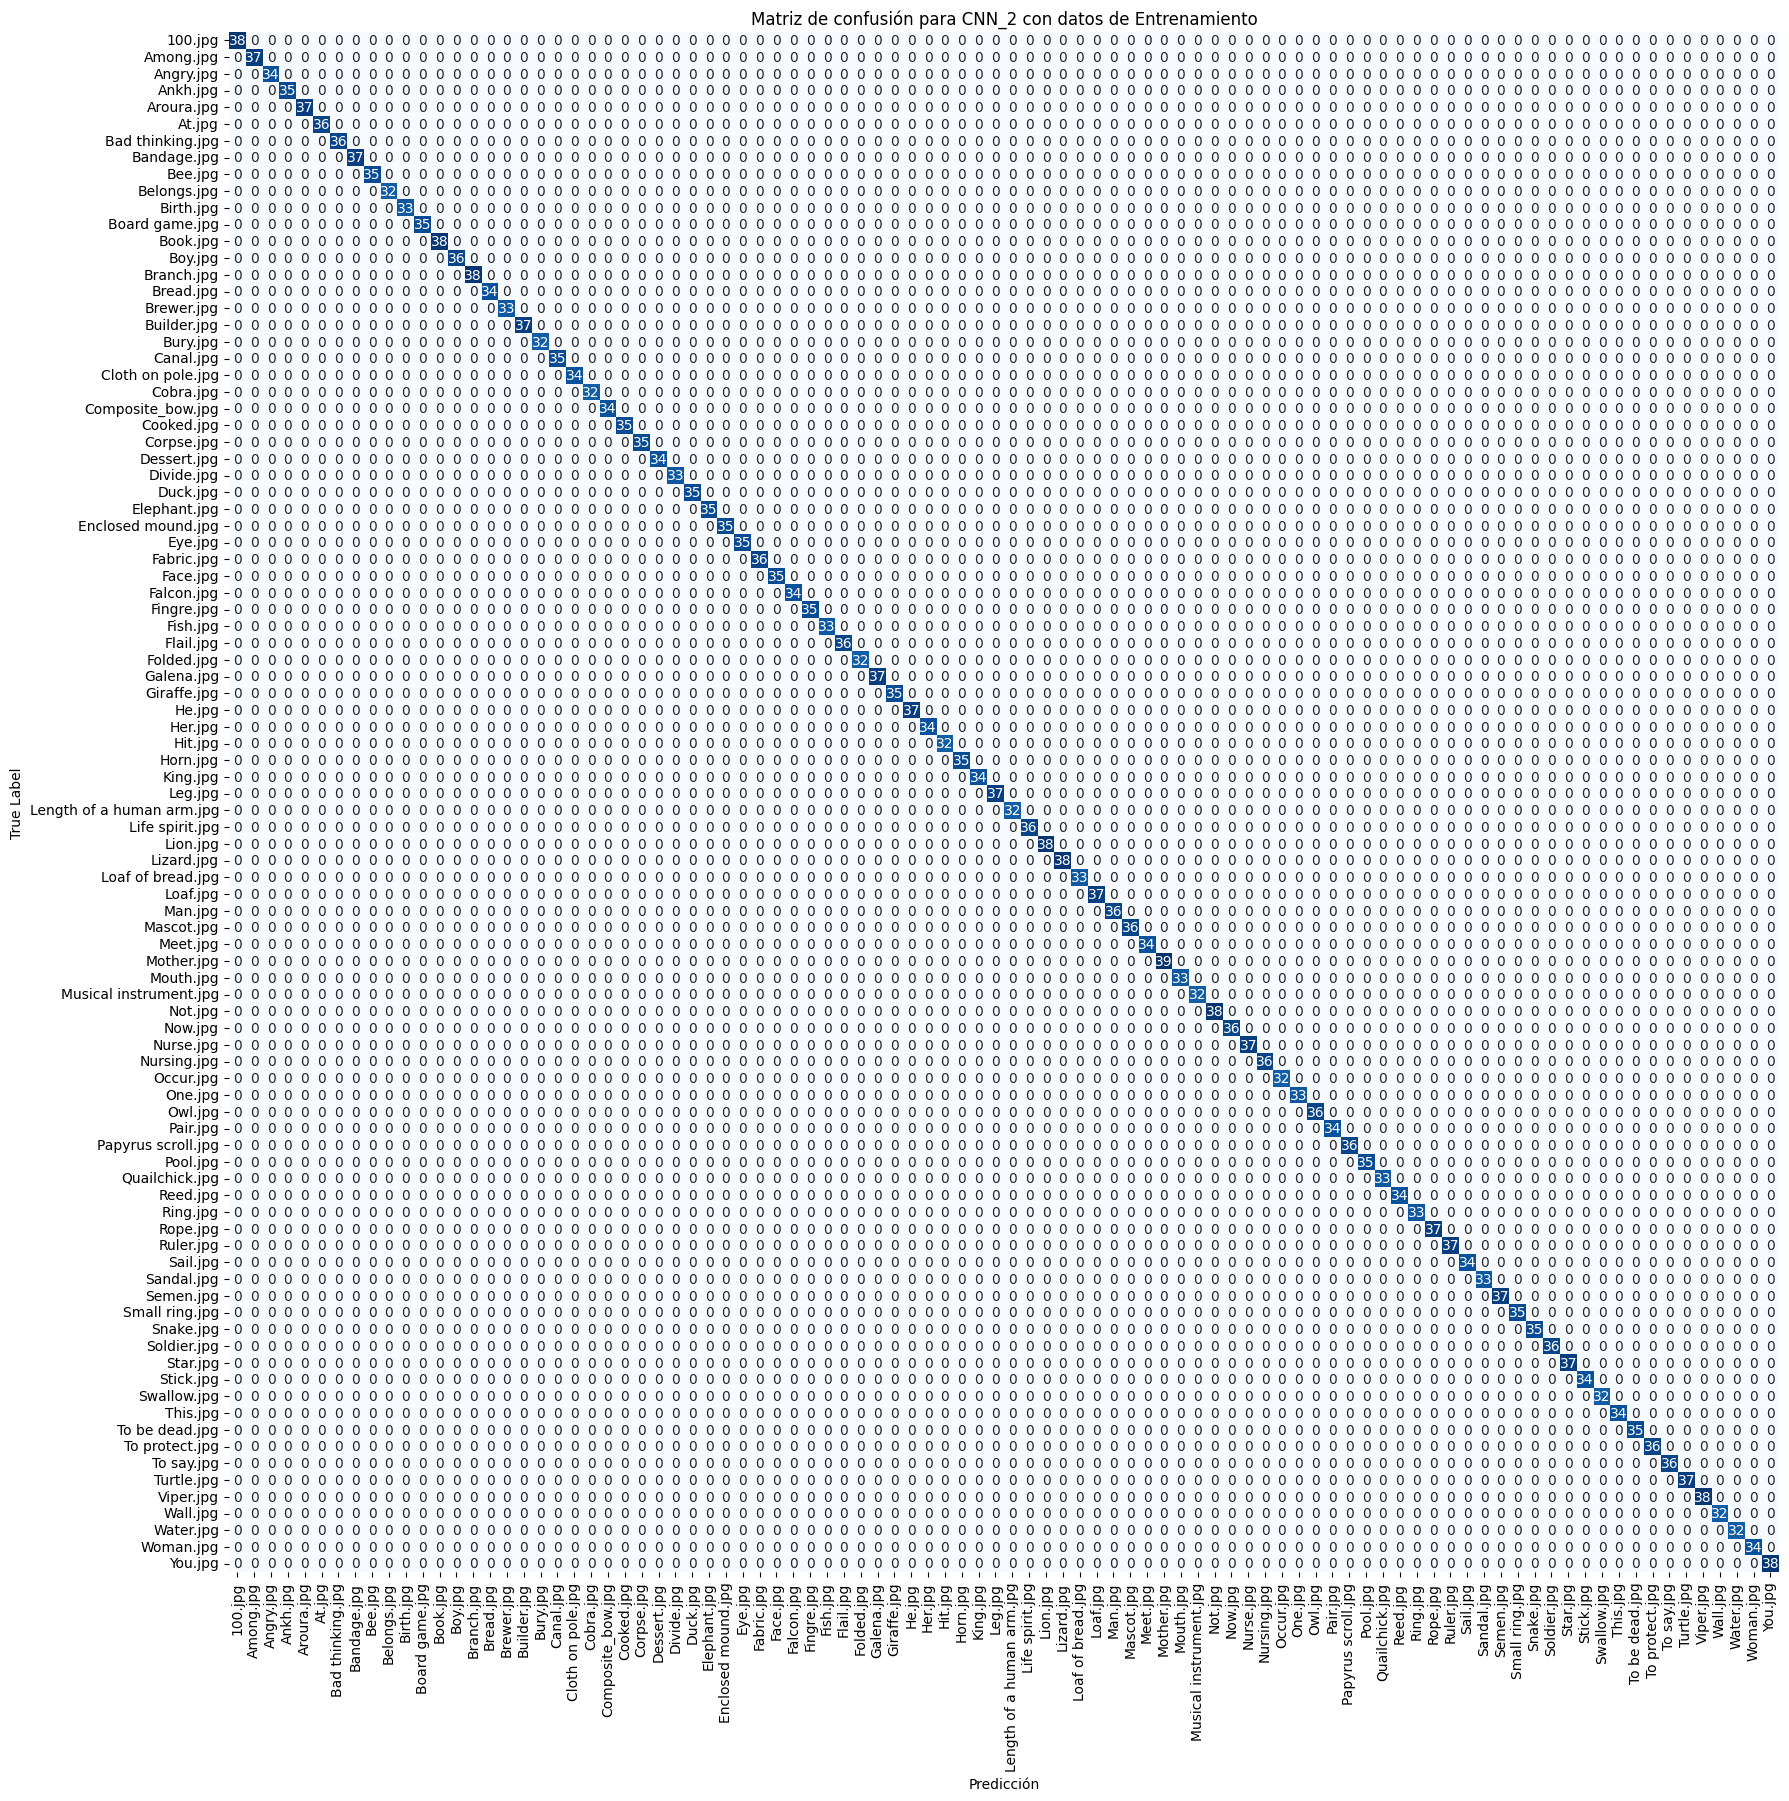

In [35]:
show_model_performance(x_train, y_train, cnn_2, "Entrenamiento", list(training_category_counts.keys()))


 Reporte de Clasificación: 
                           precision    recall  f1-score   support

                  100.jpg       1.00      1.00      1.00        13
                Among.jpg       0.93      1.00      0.96        13
                Angry.jpg       1.00      1.00      1.00        13
                 Ankh.jpg       1.00      1.00      1.00        13
               Aroura.jpg       1.00      0.85      0.92        13
                   At.jpg       0.92      0.92      0.92        13
         Bad thinking.jpg       1.00      0.92      0.96        13
              Bandage.jpg       0.92      0.92      0.92        13
                  Bee.jpg       1.00      1.00      1.00        13
              Belongs.jpg       1.00      0.92      0.96        13
                Birth.jpg       0.93      1.00      0.96        13
           Board game.jpg       1.00      1.00      1.00        13
                 Book.jpg       1.00      0.92      0.96        13
                  Boy.jpg       

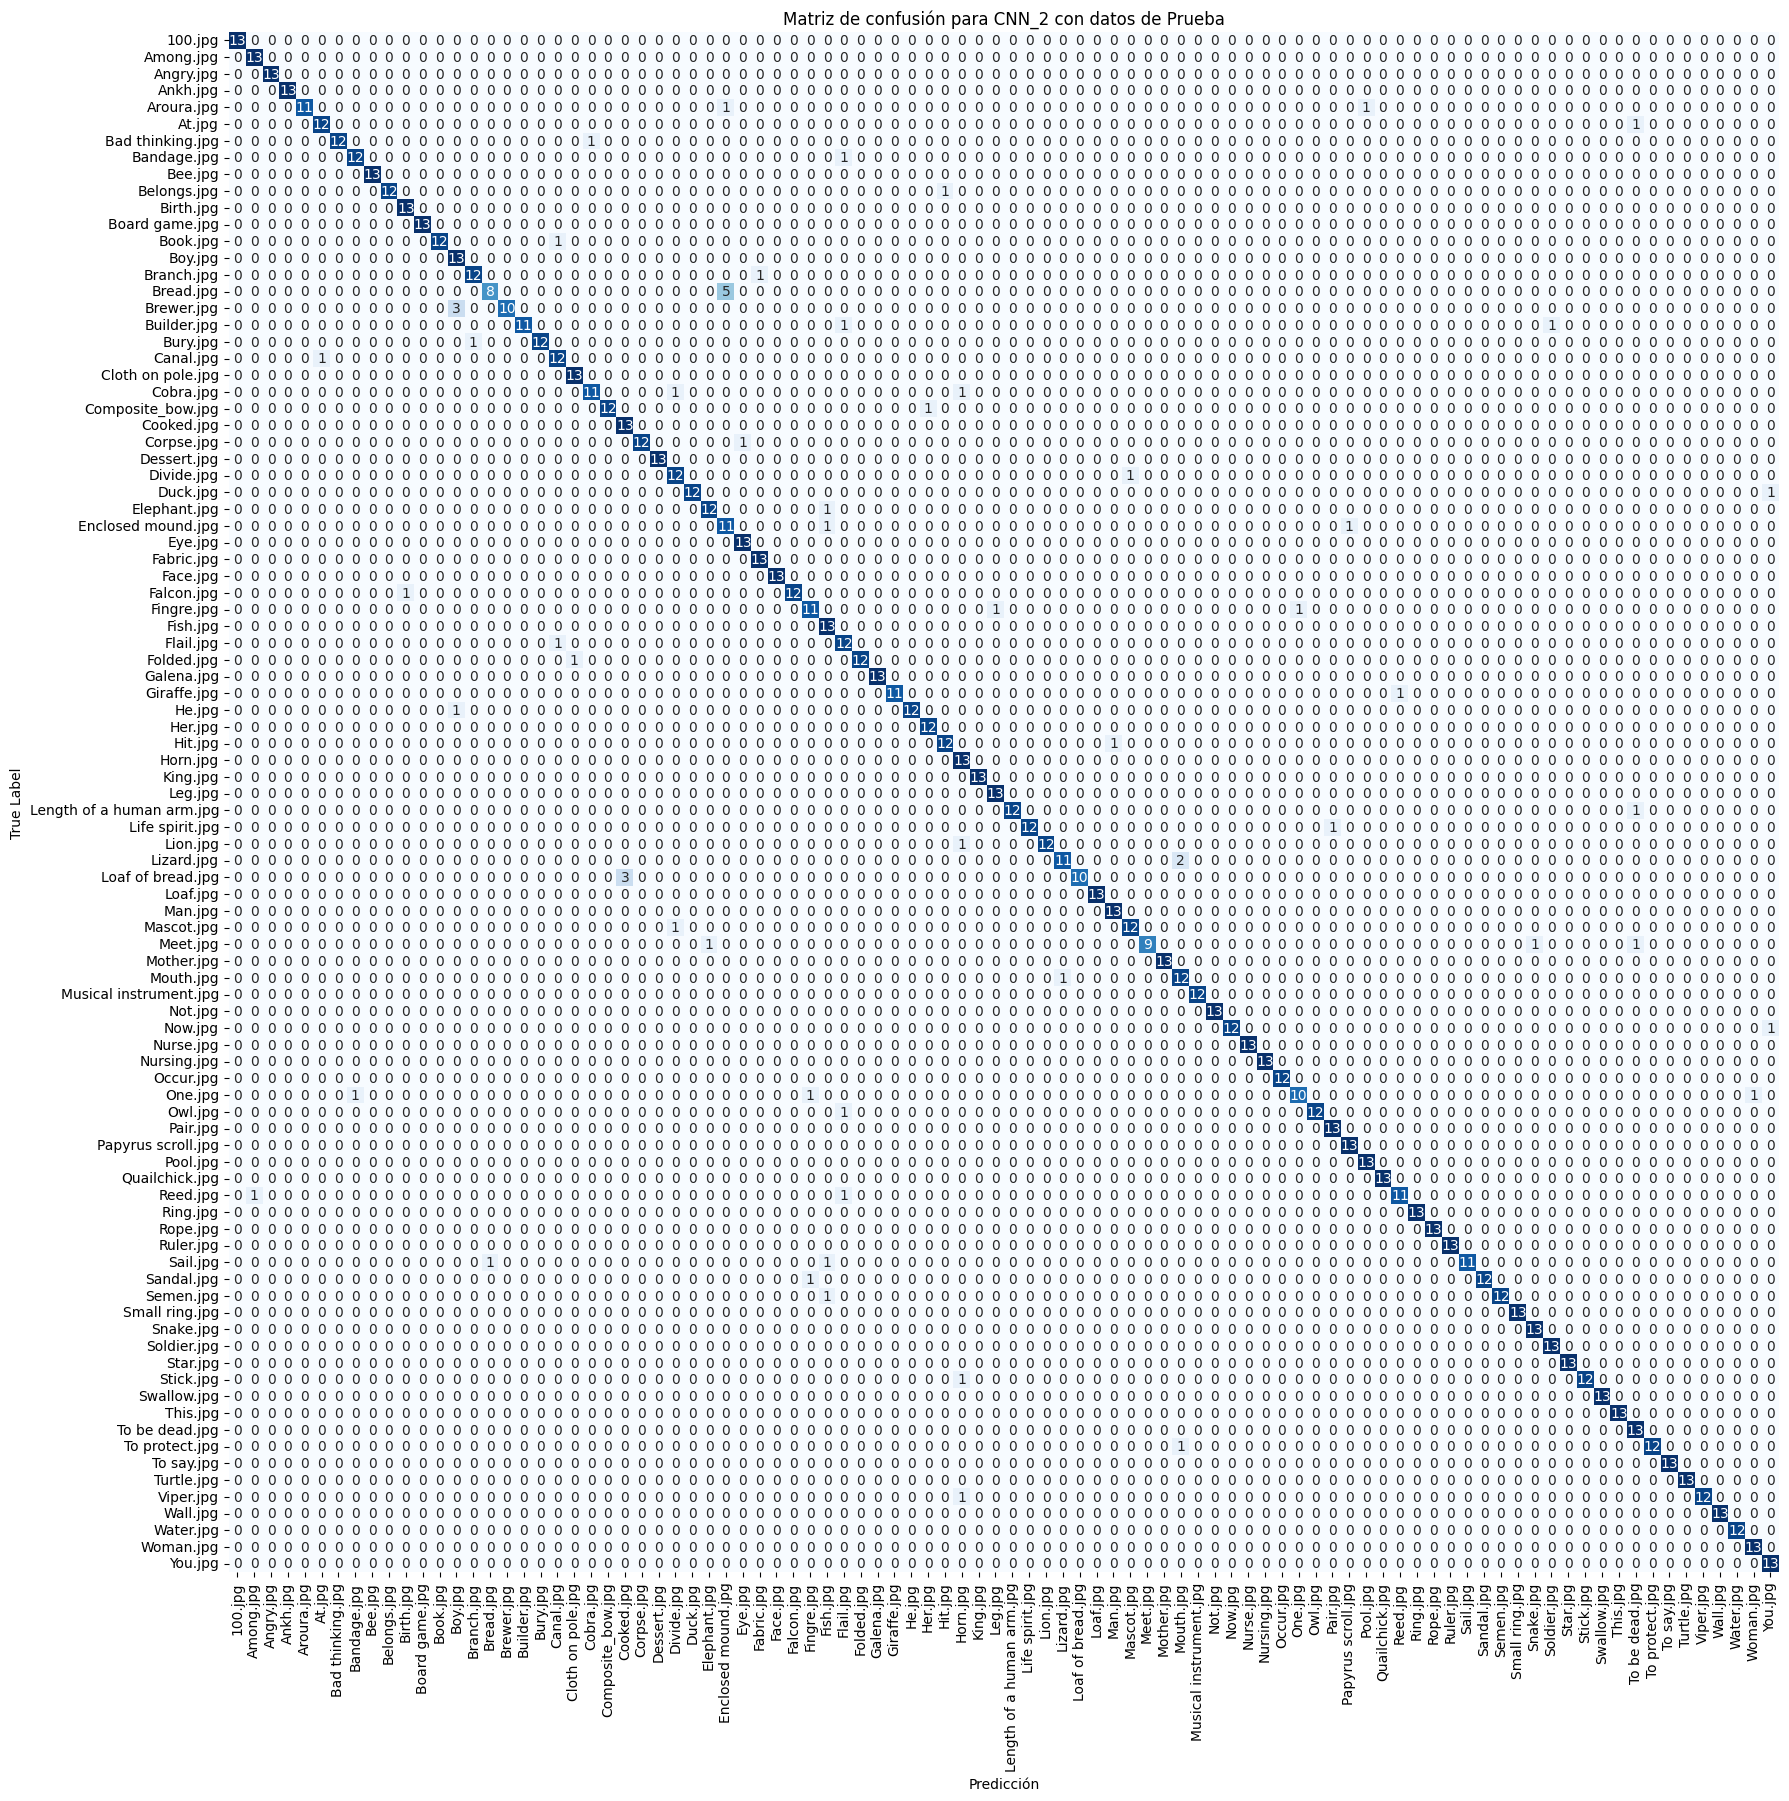

In [36]:
show_model_performance(x_test, y_test, cnn_2, "Prueba", list(training_category_counts.keys()))